# Stroke Prediction Using Clinical Data And CT

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.metrics import specificity_score
import seaborn as sns
from imblearn.over_sampling import KMeansSMOTE
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style='whitegrid')

## Load Dataset

In [2]:
# load cleaned data 
# dataset before l2 norm (PCA to autoencoder)
dataset = pd.read_csv('dataset.csv', delimiter=',', decimal='.')
dataset

Unnamed: 0  patient_id  awitan  usia  tensi_atas  tensi_bawah    pt  \
0             0           1   180.0  59.0       150.0        100.0  10.3   
1             1           2   140.0  75.0       150.0         70.0  13.0   
2             2           3   102.0  42.0       128.0         92.0  10.9   
3             3           4   120.0  48.0       150.4         90.6  10.5   
4             4           5   270.0  63.0       220.0        100.0  10.8   
..          ...         ...     ...   ...         ...          ...   ...   
140         144         144   120.0  51.0       120.0         70.0  11.9   
141         145         145   180.0  60.0       140.0         70.0  11.3   
142         146         146    15.0  32.0       140.8         89.4  11.9   
143         147         147   110.0  53.0       220.0        110.0   9.5   
144         148         148    60.0  56.7       129.1         76.9  11.1   

     pt_c  aptt  aptt_c  fibrinogen    gds   ct_axial  ct_coronal  \
0    11.6  24.1    32.4       460.6  252.0  -9.774235   -9.774235   
1    11.7  40.6    31.9       382.0  149.0  -7.666216   29.182766   
2    11.3  24.1    30.6       216.1  132.0 -13.837843  -12.401937   
3    11.7  25.7    35.8       398.5  170.7 -13.768475  -12.015924   
4    11.6  33.0    33.6       355.9  152.0   0.757949    1.136929   
..    ...   ...     ...         ...    ...        ...         ...   
140  10.9  34.7    32.4       337.2  132.0 -63.832153  -13.341796   
141  10.3  40.5    32.9       317.7  141.0 -14.381452   17.327425   
142  11.4  25.6    31.7       358.0  171.5 -12.579418  -12.579418   
143  11.2  37.5    35.3       331.0  462.0 -11.770585  -11.244816   
144  10.5  39.1    32.6       288.1  134.2 -12.691519  -12.691519   

     ct_sagittal nihss_delta_3_cat nihss_delta_2_cat  
0      -9.774235          memburuk  tidak signifikan  
1     117.886734          memburuk  tidak signifikan  
2     -11.430940          memburuk  tidak signifikan  
3     -13.768475           membaik  tidak signifikan  
4       0.757949        signifikan        signifikan  
..           ...               ...               ...  
140   -63.832153          memburuk  tidak signifikan  
141    -4.735369        signifikan        signifikan  
142  -309.691345           membaik  tidak signifikan  
143   -11.244816          memburuk  tidak signifikan  
144   -12.144307        signifikan        signifikan  

[145 rows x 17 columns]

In [3]:
# load cleaned data 
# final dataset
dataset = pd.read_csv('dataset_l2norm.csv', delimiter=',', decimal='.')
dataset

Unnamed: 0  patient_id    awitan      usia  tensi_atas  tensi_bawah  \
0             0           1  0.084363  0.082348    0.081907     0.093346   
1             1           2  0.065616  0.104680    0.081907     0.065343   
2             2           3  0.047806  0.058621    0.069894     0.085879   
3             3           4  0.056242  0.066995    0.082126     0.084572   
4             4           5  0.126544  0.087931    0.120131     0.093346   
..          ...         ...       ...       ...         ...          ...   
140         144         144  0.056242  0.071183    0.065526     0.065343   
141         145         145  0.084363  0.083744    0.076447     0.065343   
142         146         146  0.007030  0.044664    0.076884     0.083452   
143         147         147  0.051555  0.073974    0.120131     0.102681   
144         148         148  0.028121  0.079138    0.070495     0.071783   

           pt      pt_c      aptt    aptt_c  fibrinogen       gds  ct_axial  \
0    0.078607  0.086936  0.054387  0.079857    0.108844  0.118202 -0.008154   
1    0.099213  0.087685  0.091623  0.078625    0.090270  0.069889 -0.006396   
2    0.083186  0.084687  0.054387  0.075421    0.051067  0.061915 -0.011544   
3    0.080134  0.087685  0.057998  0.088237    0.094169  0.080067 -0.011486   
4    0.082423  0.086936  0.074472  0.082815    0.084103  0.071296  0.000632   
..        ...       ...       ...       ...         ...       ...       ...   
140  0.090818  0.081690  0.078308  0.079857    0.079684  0.061915 -0.053252   
141  0.086239  0.077193  0.091397  0.081090    0.075076  0.066137 -0.011998   
142  0.090818  0.085437  0.057772  0.078132    0.084599  0.080443 -0.010494   
143  0.072502  0.083938  0.084627  0.087005    0.078219  0.216703 -0.009820   
144  0.084713  0.078692  0.088238  0.080350    0.068081  0.062947 -0.010588   

     ct_coronal  ct_sagittal nihss_delta_3_cat nihss_delta_2_cat  
0     -0.008154    -0.008154          memburuk  tidak signifikan  
1      0.024346     0.098348          memburuk  tidak signifikan  
2     -0.010346    -0.009536          memburuk  tidak signifikan  
3     -0.010024    -0.011486           membaik  tidak signifikan  
4      0.000948     0.000632        signifikan        signifikan  
..          ...          ...               ...               ...  
140   -0.011130    -0.053252          memburuk  tidak signifikan  
141    0.014456    -0.003951        signifikan        signifikan  
142   -0.010494    -0.258362           membaik  tidak signifikan  
143   -0.009381    -0.009381          memburuk  tidak signifikan  
144   -0.010588    -0.010131        signifikan        signifikan  

[145 rows x 17 columns]

## data grouping

In [4]:
# ct
x_ct = dataset[['ct_axial', 'ct_coronal', 'ct_sagittal']]
x_ct

ct_axial  ct_coronal  ct_sagittal
0   -0.008154   -0.008154    -0.008154
1   -0.006396    0.024346     0.098348
2   -0.011544   -0.010346    -0.009536
3   -0.011486   -0.010024    -0.011486
4    0.000632    0.000948     0.000632
..        ...         ...          ...
140 -0.053252   -0.011130    -0.053252
141 -0.011998    0.014456    -0.003951
142 -0.010494   -0.010494    -0.258362
143 -0.009820   -0.009381    -0.009381
144 -0.010588   -0.010588    -0.010131

[145 rows x 3 columns]

In [5]:
# ct + clinic
x_ct_clinic = dataset[['ct_axial', 'ct_coronal', 'ct_sagittal', 'awitan', 'usia', 'tensi_atas', 'tensi_bawah']]
x_ct_clinic

ct_axial  ct_coronal  ct_sagittal    awitan      usia  tensi_atas  \
0   -0.008154   -0.008154    -0.008154  0.084363  0.082348    0.081907   
1   -0.006396    0.024346     0.098348  0.065616  0.104680    0.081907   
2   -0.011544   -0.010346    -0.009536  0.047806  0.058621    0.069894   
3   -0.011486   -0.010024    -0.011486  0.056242  0.066995    0.082126   
4    0.000632    0.000948     0.000632  0.126544  0.087931    0.120131   
..        ...         ...          ...       ...       ...         ...   
140 -0.053252   -0.011130    -0.053252  0.056242  0.071183    0.065526   
141 -0.011998    0.014456    -0.003951  0.084363  0.083744    0.076447   
142 -0.010494   -0.010494    -0.258362  0.007030  0.044664    0.076884   
143 -0.009820   -0.009381    -0.009381  0.051555  0.073974    0.120131   
144 -0.010588   -0.010588    -0.010131  0.028121  0.079138    0.070495   

     tensi_bawah  
0       0.093346  
1       0.065343  
2       0.085879  
3       0.084572  
4       0.093346  
..           ...  
140     0.065343  
141     0.065343  
142     0.083452  
143     0.102681  
144     0.071783  

[145 rows x 7 columns]

In [6]:
# ct + clinic + lab
x_ct_clinic_lab = dataset.drop(['Unnamed: 0', 'patient_id', 'pt_c','aptt_c', 'nihss_delta_3_cat', 'nihss_delta_2_cat'], axis=1)
x_ct_clinic_lab

awitan      usia  tensi_atas  tensi_bawah        pt      aptt  \
0    0.084363  0.082348    0.081907     0.093346  0.078607  0.054387   
1    0.065616  0.104680    0.081907     0.065343  0.099213  0.091623   
2    0.047806  0.058621    0.069894     0.085879  0.083186  0.054387   
3    0.056242  0.066995    0.082126     0.084572  0.080134  0.057998   
4    0.126544  0.087931    0.120131     0.093346  0.082423  0.074472   
..        ...       ...         ...          ...       ...       ...   
140  0.056242  0.071183    0.065526     0.065343  0.090818  0.078308   
141  0.084363  0.083744    0.076447     0.065343  0.086239  0.091397   
142  0.007030  0.044664    0.076884     0.083452  0.090818  0.057772   
143  0.051555  0.073974    0.120131     0.102681  0.072502  0.084627   
144  0.028121  0.079138    0.070495     0.071783  0.084713  0.088238   

     fibrinogen       gds  ct_axial  ct_coronal  ct_sagittal  
0      0.108844  0.118202 -0.008154   -0.008154    -0.008154  
1      0.090270  0.069889 -0.006396    0.024346     0.098348  
2      0.051067  0.061915 -0.011544   -0.010346    -0.009536  
3      0.094169  0.080067 -0.011486   -0.010024    -0.011486  
4      0.084103  0.071296  0.000632    0.000948     0.000632  
..          ...       ...       ...         ...          ...  
140    0.079684  0.061915 -0.053252   -0.011130    -0.053252  
141    0.075076  0.066137 -0.011998    0.014456    -0.003951  
142    0.084599  0.080443 -0.010494   -0.010494    -0.258362  
143    0.078219  0.216703 -0.009820   -0.009381    -0.009381  
144    0.068081  0.062947 -0.010588   -0.010588    -0.010131  

[145 rows x 11 columns]

In [7]:
# delta 3 classes
y_3 = dataset[['nihss_delta_3_cat']]
y_3

nihss_delta_3_cat
0            memburuk
1            memburuk
2            memburuk
3             membaik
4          signifikan
..                ...
140          memburuk
141        signifikan
142           membaik
143          memburuk
144        signifikan

[145 rows x 1 columns]

In [8]:
# delta 2 classes
y_2 = dataset[['nihss_delta_2_cat']]
y_2

nihss_delta_2_cat
0    tidak signifikan
1    tidak signifikan
2    tidak signifikan
3    tidak signifikan
4          signifikan
..                ...
140  tidak signifikan
141        signifikan
142  tidak signifikan
143  tidak signifikan
144        signifikan

[145 rows x 1 columns]

## Machine Learning

In [9]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize

names = [
    'AdaBoost',
    'Decision Tree',
    'Gaussian Process',
    'Linear SVM',
    'Multilayer Perceptron',
    'Naive Bayes',
    'Nearest Neighbors',
    'Quadratic Discriminant Analysis',
    'Random Forest',
    'RBF SVM'
]

classifiers = [
    AdaBoostClassifier(random_state=1),
    DecisionTreeClassifier(random_state=1),
    GaussianProcessClassifier(random_state=1),
    SVC(kernel='linear', probability=True, random_state=1),
    GaussianNB(),
    KNeighborsClassifier(),
    MLPClassifier(random_state=1),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(random_state=1),
    SVC(probability=True, random_state=1)
]

## CT

### 3 Classes

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost -  3 Classes:
[[3 3 3]
 [6 1 1]
 [5 0 2]]
Macro AUC : 0.6090707347753915
Macro Specificity : 0.6146241830065359
FPR  : [0.0, 0.06666666666666667, 0.11764705882352941, 0.125, 0.13333333333333333, 0.17647058823529413, 0.25, 0.3333333333333333, 0.375, 0.4117647058823529, 0.47058823529411764, 0.5625, 0.625, 0.6666666666666666, 0.8, 0.8666666666666667, 0.8823529411764706, 1.0]
TPR  : [0.08928571428571429, 0.16335978835978834, 0.25859788359788355, 0.3419312169312169, 0.37896825396825395, 0.42658730158730157, 0.4682539682539682, 0.5052910052910052, 0.546957671957672, 0.5945767195767195, 0.6421957671957671, 0.6838624338624338, 0.7671957671957671, 0.8042328042328042, 0.8783068783068783, 0.9153439153439153, 0.9629629629629629, 1.0]
              precision    recall  f1-score   support

     membaik       0.21      0.33      0.26         9
    memburuk       0.25      0.12      0.17         8
  signifikan       0.33      0.29      0.31         7

    accuracy                           0.

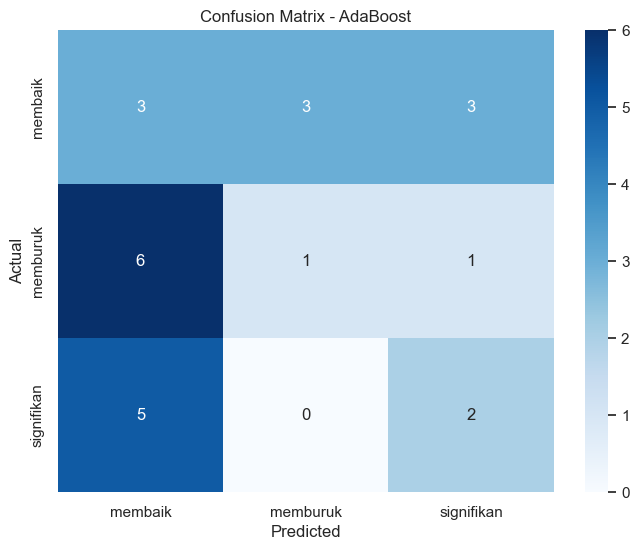

Decision Tree -  3 Classes:
[[3 2 4]
 [6 0 2]
 [3 2 2]]
Macro AUC : 0.40268440709617176
Macro Specificity : 0.5990196078431372
FPR  : [0.0, 0.25, 0.35294117647058826, 0.6, 1.0]
TPR  : [0.0, 0.11375661375661376, 0.20634920634920637, 0.4528138528138528, 1.0]
              precision    recall  f1-score   support

     membaik       0.25      0.33      0.29         9
    memburuk       0.00      0.00      0.00         8
  signifikan       0.25      0.29      0.27         7

    accuracy                           0.21        24
   macro avg       0.17      0.21      0.18        24
weighted avg       0.17      0.21      0.18        24



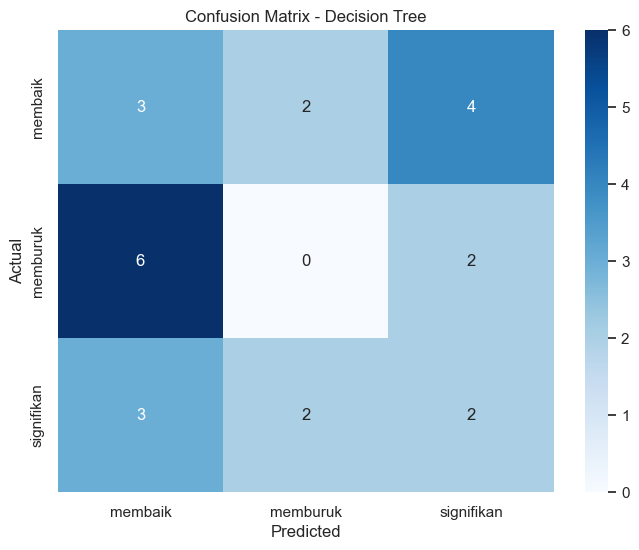

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

Gaussian Process -  3 Classes:
[[9 0 0]
 [8 0 0]
 [6 0 1]]
Macro AUC : 0.40407264757754957
Macro Specificity : 0.6888888888888888
FPR  : [0.0, 0.0625, 0.06666666666666667, 0.11764705882352941, 0.13333333333333333, 0.23529411764705882, 0.26666666666666666, 0.375, 0.4375, 0.5294117647058824, 0.5333333333333333, 0.5882352941176471, 0.625, 0.6666666666666666, 0.7058823529411765, 0.7333333333333333, 0.8125, 0.875, 0.9333333333333333, 0.9375, 1.0]
TPR  : [0.047619047619047616, 0.047619047619047616, 0.047619047619047616, 0.09523809523809523, 0.13227513227513227, 0.17989417989417988, 0.2169312169312169, 0.25859788359788355, 0.30026455026455023, 0.34788359788359785, 0.3849206349206349, 0.48015873015873006, 0.5218253968253967, 0.5588624338624338, 0.6064814814814815, 0.6435185185185185, 0.7268518518518517, 0.8101851851851851, 0.9583333333333334, 1.0, 1.0]
              precision    recall  f1-score   support

     membaik       0.39      1.00      0.56         9
    memburuk       0.00      0.00 

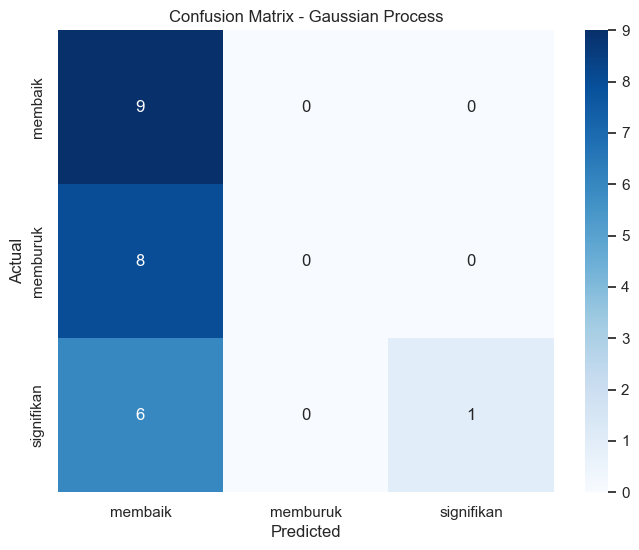

Linear SVM -  3 Classes:
[[9 0 0]
 [8 0 0]
 [7 0 0]]
Macro AUC : 0.4150093370681606
Macro Specificity : 0.6666666666666666
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.1875, 0.2, 0.26666666666666666, 0.29411764705882354, 0.35294117647058826, 0.4375, 0.47058823529411764, 0.5333333333333333, 0.625, 0.6666666666666666, 0.6875, 0.8235294117647058, 0.8666666666666667, 0.875, 0.8823529411764706, 1.0]
TPR  : [0.0, 0.0, 0.0, 0.037037037037037035, 0.0787037037037037, 0.11574074074074074, 0.15277777777777776, 0.20039682539682538, 0.29563492063492064, 0.37896825396825395, 0.42658730158730157, 0.5006613756613757, 0.5423280423280423, 0.6164021164021164, 0.658068783068783, 0.7056878306878307, 0.7427248677248678, 0.8677248677248678, 0.9153439153439153, 1.0]
              precision    recall  f1-score   support

     membaik       0.38      1.00      0.55         9
    memburuk       0.00      0.00      0.00         8
  signifikan       0.00      0.00      0.00         7

    accu

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

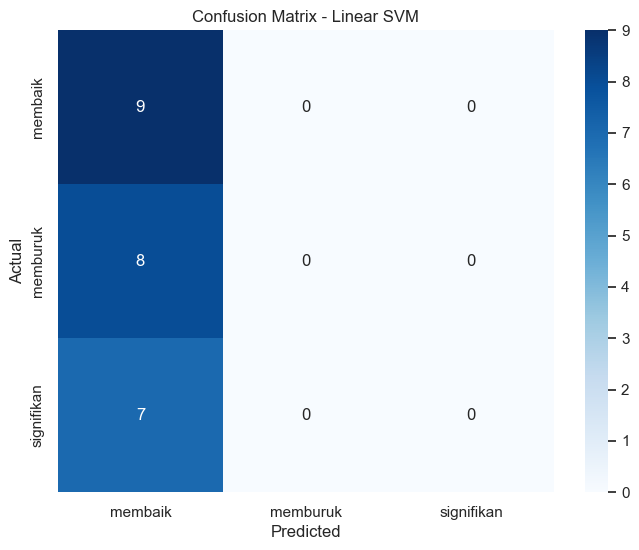

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Multilayer Perceptron -  3 Classes:
[[5 3 1]
 [7 1 0]
 [7 0 0]]
Macro AUC : 0.33637177093059445
Macro Specificity : 0.6067810457516339
FPR  : [0.0, 0.058823529411764705, 0.06666666666666667, 0.26666666666666666, 0.3125, 0.375, 0.4117647058823529, 0.5, 0.5294117647058824, 0.5333333333333333, 0.6, 0.6666666666666666, 0.6875, 0.7647058823529411, 0.8235294117647058, 0.875, 0.9333333333333333, 1.0]
TPR  : [0.041666666666666664, 0.041666666666666664, 0.041666666666666664, 0.11574074074074074, 0.1574074074074074, 0.19907407407407407, 0.24669312169312171, 0.28835978835978837, 0.335978835978836, 0.373015873015873, 0.41005291005291006, 0.44708994708994715, 0.4887566137566138, 0.5363756613756614, 0.6792328042328042, 0.8042328042328042, 0.8783068783068783, 1.0]
              precision    recall  f1-score   support

     membaik       0.26      0.56      0.36         9
    memburuk       0.25      0.12      0.17         8
  signifikan       0.00      0.00      0.00         7

    accuracy          

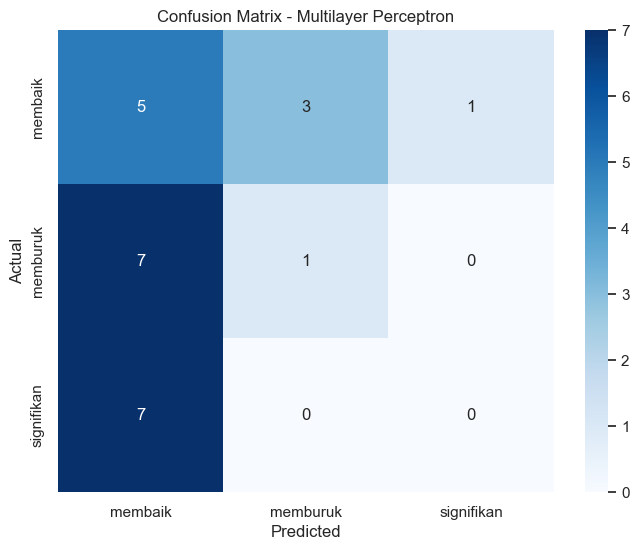

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Naive Bayes -  3 Classes:
[[3 5 1]
 [7 1 0]
 [4 1 2]]
Macro AUC : 0.4621363244371823
Macro Specificity : 0.6109477124183006
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.2, 0.25, 0.29411764705882354, 0.4666666666666667, 0.5, 0.8, 0.8125, 0.8235294117647058, 0.9333333333333333, 1.0]
TPR  : [0.047619047619047616, 0.10613134142545906, 0.10830026455026454, 0.21997354497354493, 0.25132275132275134, 0.27653283535636475, 0.35185185185185186, 0.3738095238095238, 0.7214285714285715, 0.753968253968254, 0.7777777777777777, 0.9851851851851853, 1.0]
              precision    recall  f1-score   support

     membaik       0.21      0.33      0.26         9
    memburuk       0.14      0.12      0.13         8
  signifikan       0.67      0.29      0.40         7

    accuracy                           0.25        24
   macro avg       0.34      0.25      0.26        24
weighted avg       0.32      0.25      0.26        24



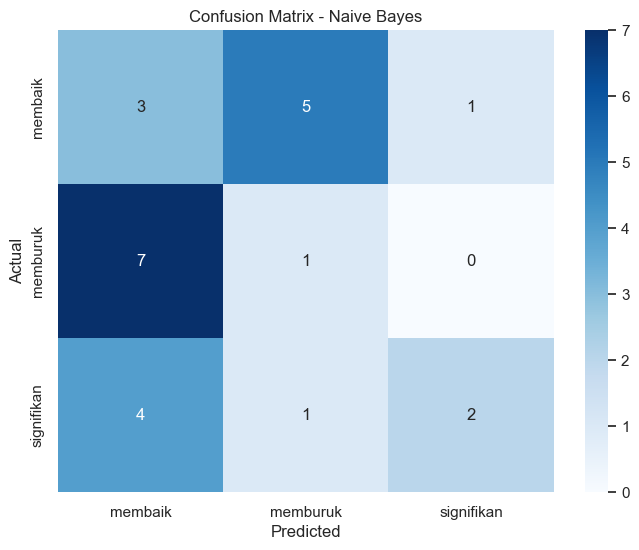

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Nearest Neighbors -  3 Classes:
[[8 1 0]
 [8 0 0]
 [6 0 1]]
Macro AUC : 0.42892140652557315
Macro Specificity : 0.6680555555555555
FPR  : [0.0, 0.0625, 0.06666666666666667, 0.13333333333333333, 0.1875, 0.2, 0.23529411764705882, 0.35294117647058826, 0.4, 0.4375, 0.4666666666666667, 0.5294117647058824, 0.5625, 0.5882352941176471, 0.6470588235294118, 0.8125, 0.875, 0.9333333333333333, 1.0]
TPR  : [0.047619047619047616, 0.047619047619047616, 0.047619047619047616, 0.08465608465608465, 0.1263227513227513, 0.16335978835978834, 0.21097883597883596, 0.25859788359788355, 0.29563492063492064, 0.33730158730158727, 0.37433862433862436, 0.4219576719576719, 0.5052910052910052, 0.5529100529100529, 0.6481481481481481, 0.7731481481481483, 0.8148148148148149, 1.0, 1.0]
              precision    recall  f1-score   support

     membaik       0.36      0.89      0.52         9
    memburuk       0.00      0.00      0.00         8
  signifikan       1.00      0.14      0.25         7

    accuracy         

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


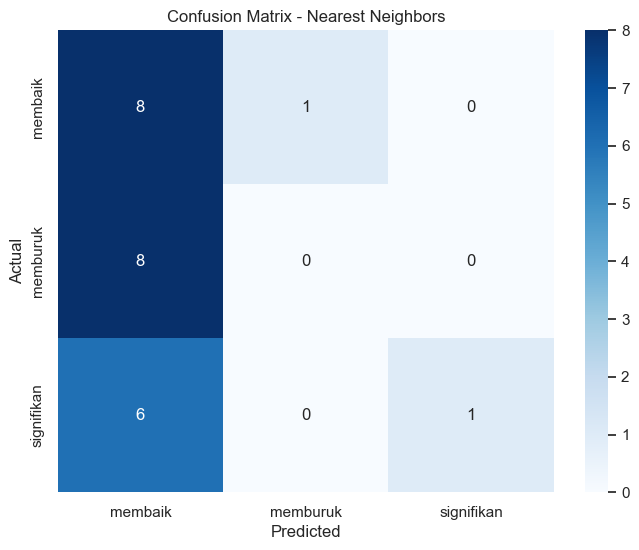

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

Quadratic Discriminant Analysis -  3 Classes:
[[6 3 0]
 [7 1 0]
 [7 0 0]]
Macro AUC : 0.45698561832140266
Macro Specificity : 0.6263888888888889
FPR  : [0.0, 0.058823529411764705, 0.06666666666666667, 0.17647058823529413, 0.26666666666666666, 0.375, 0.4, 0.4117647058823529, 0.47058823529411764, 0.5294117647058824, 0.5333333333333333, 0.5625, 0.6470588235294118, 0.6875, 0.7333333333333333, 0.875, 0.9333333333333333, 1.0]
TPR  : [0.041666666666666664, 0.041666666666666664, 0.0787037037037037, 0.1263227513227513, 0.2374338624338624, 0.32076719576719576, 0.3578042328042328, 0.40542328042328046, 0.4530423280423281, 0.5006613756613757, 0.5376984126984127, 0.5793650793650793, 0.6746031746031745, 0.7162698412698413, 0.7533068783068783, 0.8783068783068783, 0.9153439153439153, 1.0]
              precision    recall  f1-score   support

     membaik       0.30      0.67      0.41         9
    memburuk       0.25      0.12      0.17         8
  signifikan       0.00      0.00      0.00         7


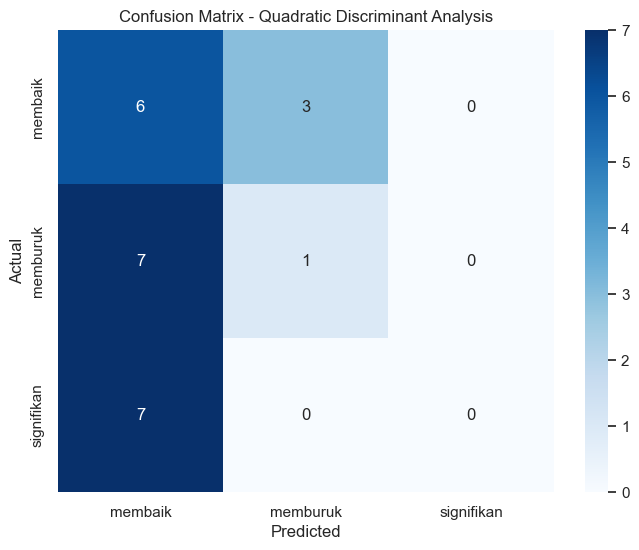

/var/folders/sq/_27zqsss0s304lxljksdbb4r0000gn/T/ipykernel_36040/1294366471.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


Random Forest -  3 Classes:
[[3 4 2]
 [5 2 1]
 [3 2 2]]
Macro AUC : 0.4901279145917627
Macro Specificity : 0.6383986928104576
FPR  : [0.0, 0.0625, 0.06666666666666667, 0.125, 0.25, 0.26666666666666666, 0.3333333333333333, 0.4666666666666667, 0.47058823529411764, 0.5, 0.5294117647058824, 0.5625, 0.6, 0.625, 0.6470588235294118, 0.6666666666666666, 0.7058823529411765, 0.7647058823529411, 0.8, 0.875, 0.8823529411764706, 0.9375, 1.0]
TPR  : [0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.1369047619047619, 0.17857142857142858, 0.17857142857142858, 0.2526455026455026, 0.28968253968253965, 0.33730158730158727, 0.46230158730158727, 0.6051587301587301, 0.6051587301587301, 0.6671957671957672, 0.6838624338624338, 0.6838624338624338, 0.7738095238095237, 0.8055555555555555, 0.8055555555555555, 0.9166666666666666, 0.9583333333333334, 0.9583333333333334, 1.0, 1.0]
              precision    recall  f1-score   support

     membaik       0.27      0.33      0.30         9
    memburuk

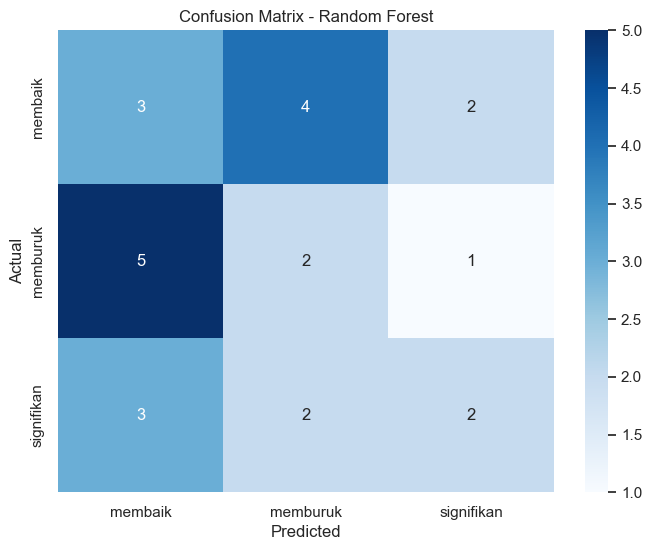

RBF SVM -  3 Classes:
[[9 0 0]
 [8 0 0]
 [7 0 0]]
Macro AUC : 0.5619065450254176
Macro Specificity : 0.6666666666666666
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.125, 0.13333333333333333, 0.17647058823529413, 0.23529411764705882, 0.26666666666666666, 0.3125, 0.375, 0.5294117647058824, 0.5333333333333333, 0.5882352941176471, 0.6875, 0.7333333333333333, 0.75, 0.8, 1.0]
TPR  : [0.041666666666666664, 0.041666666666666664, 0.08333333333333333, 0.08333333333333333, 0.125, 0.27314814814814814, 0.32076719576719576, 0.416005291005291, 0.4530423280423281, 0.4947089947089947, 0.5363756613756614, 0.6316137566137566, 0.6686507936507936, 0.7162698412698413, 0.7579365079365079, 0.794973544973545, 0.8366402116402116, 0.8736772486772487, 1.0]
              precision    recall  f1-score   support

     membaik       0.38      1.00      0.55         9
    memburuk       0.00      0.00      0.00         8
  signifikan       0.00      0.00      0.00         7

    accuracy          

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

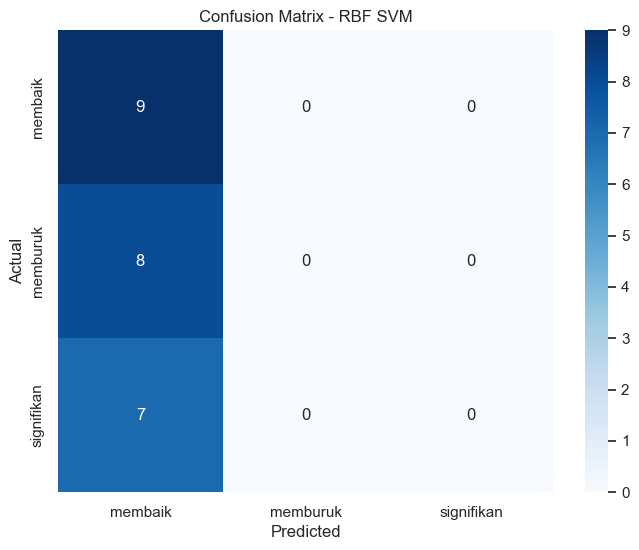

In [11]:
x = pd.concat([x_ct.iloc[0:33], x_ct.iloc[57:]])
y = pd.concat([y_3.iloc[0:33], y_3.iloc[57:]])
x_test = x_ct.iloc[33:57]
y_test = y_3.iloc[33:57]
x_train = x
y_train = y

for name, model in zip(names, classifiers):
    fpr_all = []
    tpr_all = []

    # Train the classifier on the training data
    model.fit(x_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)

    fpr = dict()
    tpr = dict()
    y_test_binarizer = label_binarize(y_test, classes=model.classes_)
    for i in range(len(model.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarizer[:, i], y_pred_proba[:, i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(model.classes_))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(model.classes_)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(model.classes_)

    fpr_all.append(all_fpr)
    tpr_all.append(mean_tpr)

    # Calculate metrics for this fold
    class_report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba, labels=model.classes_, multi_class="ovr", average="macro")
    print(f"{name} -  3 Classes:")
    print(confusion_matrix(y_test, y_pred))
    print(f'Macro AUC : {auc}')
    print(f'Macro Specificity : {specificity_score(y_test, y_pred, labels=model.classes_, average="macro")}')
    print(f'FPR  : {fpr_all[0].tolist()}')
    print(f'TPR  : {tpr_all[0].tolist()}')
    print(class_report)
    # Print heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.savefig(f'images/charts/cf_dataval_ct_3_classes_{name.lower().replace(" ", "_")}.png') 
    plt.show()

### 2 Classes

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost -  2 Classes:
[[ 5  2]
 [ 4 13]]
AUC : 0.73109243697479
Macro Specificity : 0.7394957983193278
FPR  : [0.0, 0.0, 0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.7142857142857143, 0.7142857142857143, 1.0, 1.0]
TPR  : [0.0, 0.058823529411764705, 0.23529411764705882, 0.23529411764705882, 0.5882352941176471, 0.5882352941176471, 0.7647058823529411, 0.7647058823529411, 0.8235294117647058, 0.8235294117647058, 0.9411764705882353, 0.9411764705882353, 1.0]
TN, FP, FN, TP : [ 5  2  4 13]
                  precision    recall  f1-score   support

      signifikan       0.56      0.71      0.63         7
tidak signifikan       0.87      0.76      0.81        17

        accuracy                           0.75        24
       macro avg       0.71      0.74      0.72        24
    weighted avg       0.78      0.75      0.76        24



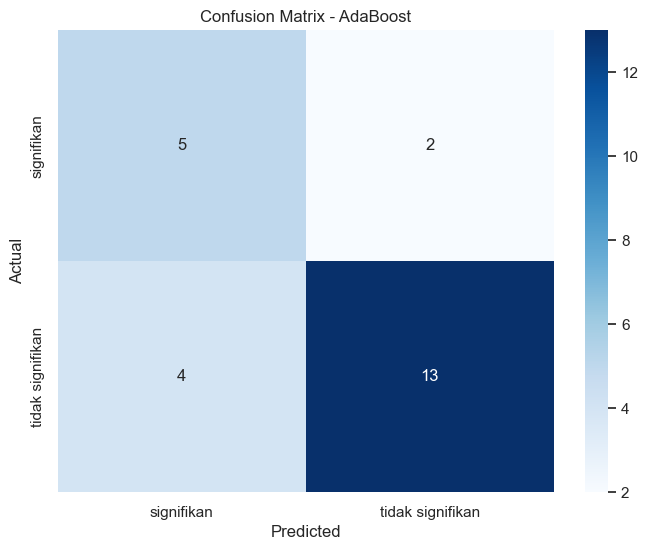

Decision Tree -  2 Classes:
[[ 2  5]
 [ 4 13]]
AUC : 0.5252100840336134
Macro Specificity : 0.5252100840336134
FPR  : [0.0, 0.7142857142857143, 1.0]
TPR  : [0.0, 0.7647058823529411, 1.0]
TN, FP, FN, TP : [ 2  5  4 13]
                  precision    recall  f1-score   support

      signifikan       0.33      0.29      0.31         7
tidak signifikan       0.72      0.76      0.74        17

        accuracy                           0.62        24
       macro avg       0.53      0.53      0.53        24
    weighted avg       0.61      0.62      0.62        24



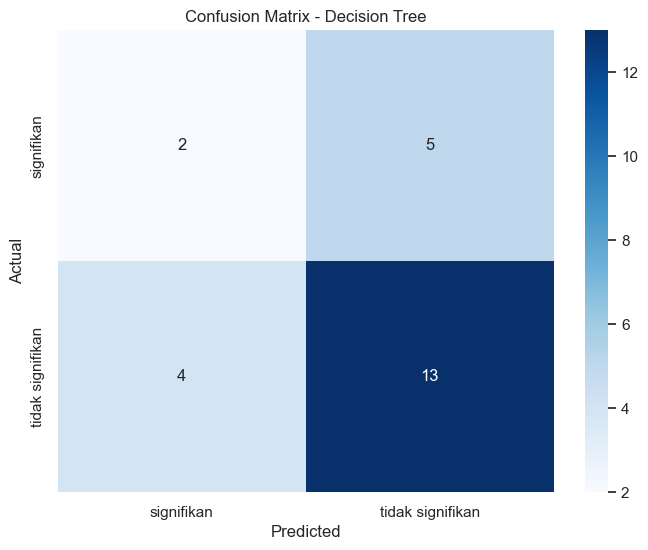

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

Gaussian Process -  2 Classes:
[[ 0  7]
 [ 0 17]]
AUC : 0.5798319327731092
Macro Specificity : 0.5
FPR  : [0.0, 0.0, 0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0]
TPR  : [0.0, 0.058823529411764705, 0.29411764705882354, 0.29411764705882354, 0.4117647058823529, 0.4117647058823529, 0.47058823529411764, 0.47058823529411764, 0.6470588235294118, 0.6470588235294118, 0.7647058823529411, 0.7647058823529411, 1.0, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg       0.50      0.71      0.59        24



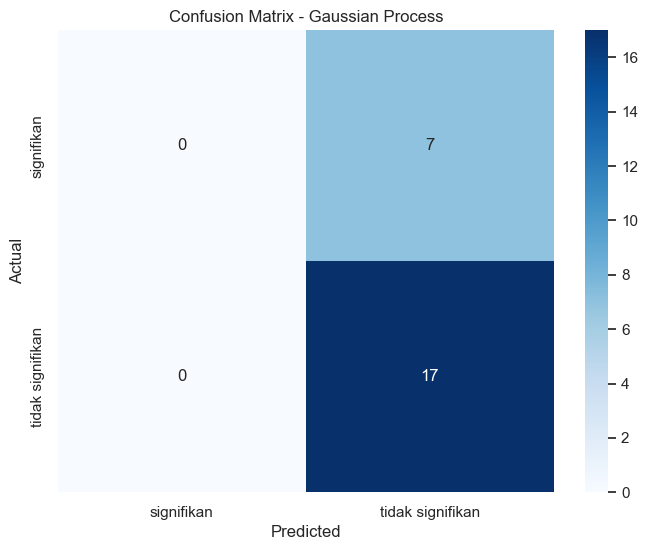

Linear SVM -  2 Classes:
[[ 0  7]
 [ 0 17]]
AUC : 0.4117647058823529
Macro Specificity : 0.5
FPR  : [0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0]
TPR  : [0.0, 0.0, 0.23529411764705882, 0.23529411764705882, 0.29411764705882354, 0.29411764705882354, 0.5294117647058824, 0.5294117647058824, 0.5882352941176471, 0.5882352941176471, 0.6470588235294118, 0.6470588235294118, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg       0.50      0.71      0.59        24



/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

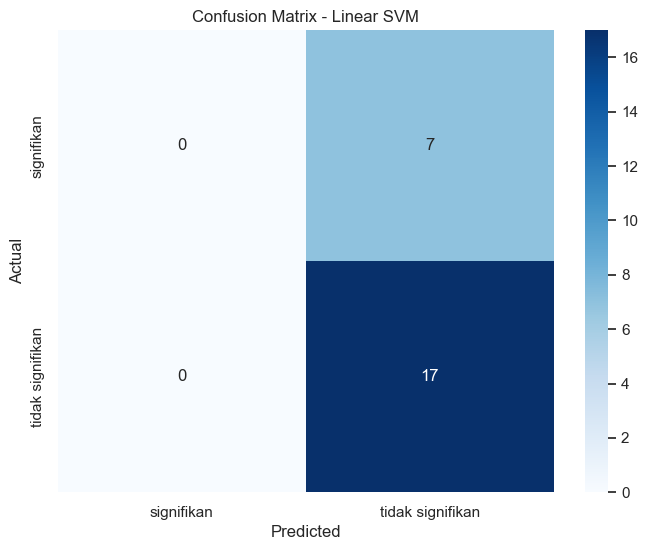

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Multilayer Perceptron -  2 Classes:
[[ 0  7]
 [ 1 16]]
AUC : 0.4201680672268908
Macro Specificity : 0.47058823529411764
FPR  : [0.0, 0.14285714285714285, 0.14285714285714285, 0.42857142857142855, 0.42857142857142855, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0]
TPR  : [0.0, 0.0, 0.35294117647058826, 0.35294117647058826, 0.47058823529411764, 0.47058823529411764, 0.5294117647058824, 0.5294117647058824, 0.7647058823529411, 0.7647058823529411, 1.0]
TN, FP, FN, TP : [ 0  7  1 16]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.70      0.94      0.80        17

        accuracy                           0.67        24
       macro avg       0.35      0.47      0.40        24
    weighted avg       0.49      0.67      0.57        24



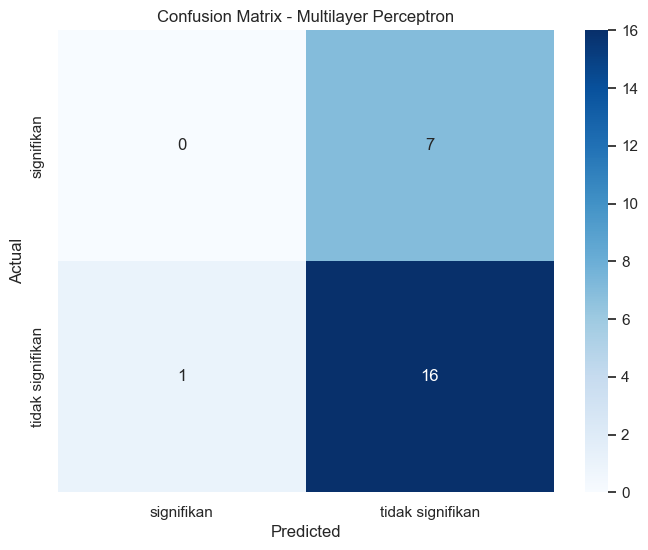

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Naive Bayes -  2 Classes:
[[ 2  5]
 [ 1 16]]
AUC : 0.7058823529411765
Macro Specificity : 0.6134453781512605
FPR  : [0.0, 0.0, 0.42857142857142855, 0.7142857142857143, 0.8571428571428571, 1.0]
TPR  : [0.0, 0.17647058823529413, 0.7058823529411765, 0.9411764705882353, 1.0, 1.0]
TN, FP, FN, TP : [ 2  5  1 16]
                  precision    recall  f1-score   support

      signifikan       0.67      0.29      0.40         7
tidak signifikan       0.76      0.94      0.84        17

        accuracy                           0.75        24
       macro avg       0.71      0.61      0.62        24
    weighted avg       0.73      0.75      0.71        24



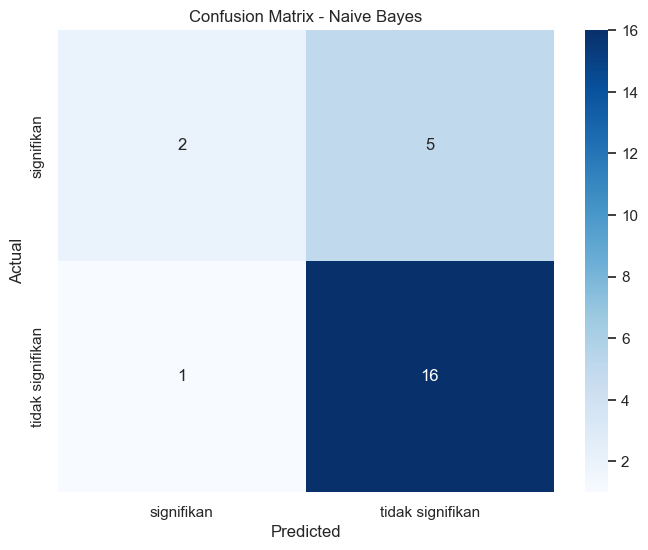

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Nearest Neighbors -  2 Classes:
[[ 0  7]
 [ 0 17]]
AUC : 0.6218487394957983
Macro Specificity : 0.5
FPR  : [0.0, 0.0, 0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0]
TPR  : [0.0, 0.058823529411764705, 0.29411764705882354, 0.29411764705882354, 0.35294117647058826, 0.35294117647058826, 0.4117647058823529, 0.4117647058823529, 0.5882352941176471, 0.5882352941176471, 0.8235294117647058, 0.8235294117647058, 0.8823529411764706, 0.8823529411764706, 1.0, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg

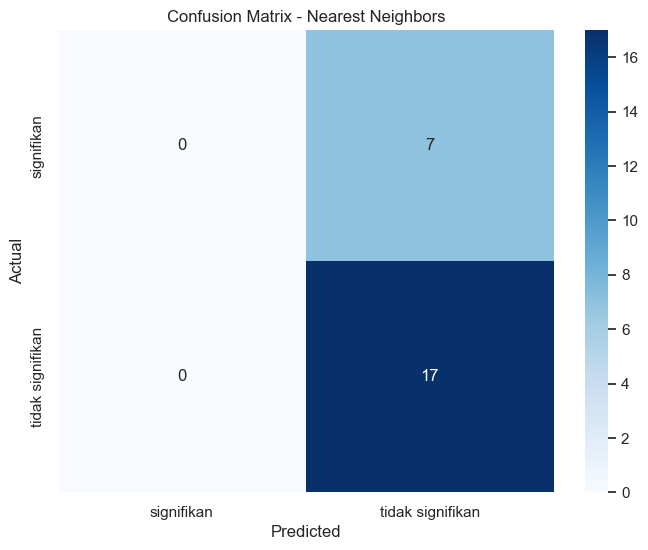

Quadratic Discriminant Analysis -  2 Classes:
[[ 0  7]
 [ 0 17]]
AUC : 0.48739495798319327
Macro Specificity : 0.5
FPR  : [0.0, 0.14285714285714285, 0.14285714285714285, 0.42857142857142855, 0.42857142857142855, 0.7142857142857143, 0.7142857142857143, 1.0, 1.0]
TPR  : [0.0, 0.0, 0.4117647058823529, 0.4117647058823529, 0.5294117647058824, 0.5294117647058824, 0.7647058823529411, 0.7647058823529411, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg       0.50      0.71      0.59        24



/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

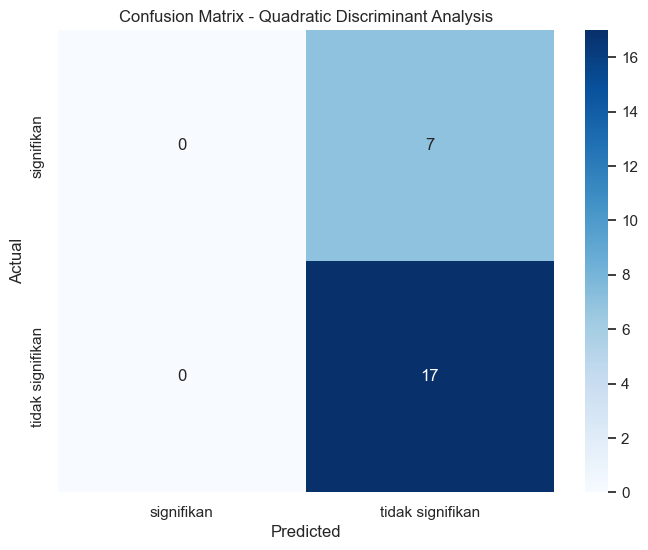

/var/folders/sq/_27zqsss0s304lxljksdbb4r0000gn/T/ipykernel_45662/2092826265.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


Random Forest -  2 Classes:
[[ 2  5]
 [ 2 15]]
AUC : 0.680672268907563
Macro Specificity : 0.5840336134453781
FPR  : [0.0, 0.0, 0.0, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 1.0]
TPR  : [0.0, 0.058823529411764705, 0.4117647058823529, 0.4117647058823529, 0.47058823529411764, 0.5294117647058824, 0.6470588235294118, 0.7058823529411765, 0.7647058823529411, 0.7647058823529411, 1.0, 1.0]
TN, FP, FN, TP : [ 2  5  2 15]
                  precision    recall  f1-score   support

      signifikan       0.50      0.29      0.36         7
tidak signifikan       0.75      0.88      0.81        17

        accuracy                           0.71        24
       macro avg       0.62      0.58      0.59        24
    weighted avg       0.68      0.71      0.68        24



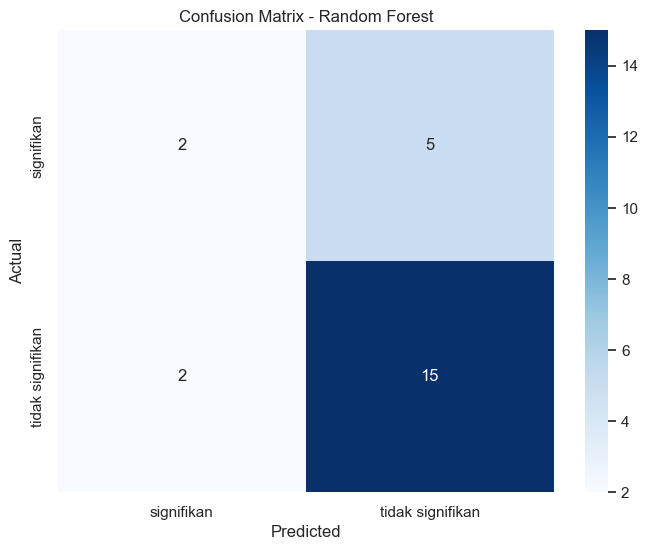

RBF SVM -  2 Classes:
[[ 0  7]
 [ 0 17]]
AUC : 0.546218487394958
Macro Specificity : 0.5
FPR  : [0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0]
TPR  : [0.0, 0.0, 0.4117647058823529, 0.4117647058823529, 0.47058823529411764, 0.47058823529411764, 0.7058823529411765, 0.7058823529411765, 0.8235294117647058, 0.8235294117647058, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg       0.50      0.71      0.59        24



/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

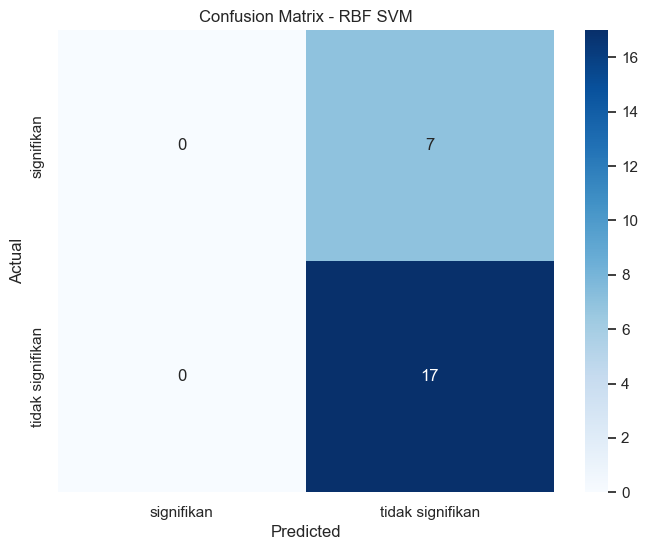

In [56]:
x = pd.concat([x_ct.iloc[0:33], x_ct.iloc[57:]])
y = pd.concat([y_2.iloc[0:33], y_2.iloc[57:]])
x_test = x_ct.iloc[33:57]
y_test = y_2.iloc[33:57]
x_train = x
y_train = y

for name, model in zip(names, classifiers):
    fpr_all = []
    tpr_all = []

    # Train the classifier on the training data
    model.fit(x_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)

    y_test_binarizer = label_binarize(y_test, classes=model.classes_)
    fpr, tpr, _ = roc_curve(y_test_binarizer, y_pred_proba[:, 1])

    fpr_all.append(fpr)
    tpr_all.append(tpr)

    # Calculate metrics for this fold
    class_report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba[:,1])

    print(f"{name} -  2 Classes:")
    print(confusion_matrix(y_test, y_pred))
    print(f'AUC : {auc}')
    print(f'Macro Specificity : {specificity_score(y_test, y_pred, labels=model.classes_, average="macro")}')
    print(f'FPR  : {fpr_all[0].tolist()}')
    print(f'TPR  : {tpr_all[0].tolist()}')
    print(f'TN, FP, FN, TP : {confusion_matrix(y_test, y_pred).ravel()}')
    print(class_report)
    # Print heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.savefig(f'images/charts/cf_dataval_ct_2_classes_{name.lower().replace(" ", "_")}.png') 
    plt.show()

## CT + Klinis

### 3 Classes

AdaBoost -  3 Classes:

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[[2 4 3]
 [4 2 2]
 [2 1 4]]
Macro AUC : 0.5787314231248055
Macro Specificity : 0.6644607843137256
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.11764705882352941, 0.35294117647058826, 0.375, 0.4375, 0.47058823529411764, 0.5333333333333333, 0.5625, 0.6, 0.625, 0.6875, 0.8666666666666667, 0.875, 0.9333333333333333, 1.0]
TPR  : [0.047619047619047616, 0.09523809523809523, 0.09523809523809523, 0.24338624338624337, 0.3386243386243386, 0.3862433862433862, 0.5112433862433862, 0.5529100529100529, 0.6005291005291005, 0.6375661375661376, 0.6792328042328042, 0.7533068783068783, 0.794973544973545, 0.8366402116402116, 0.8736772486772487, 0.9153439153439153, 0.9523809523809524, 1.0]
              precision    recall  f1-score   support

     membaik       0.25      0.22      0.24         9
    memburuk       0.29      0.25      0.27         8
  signifikan       0.44      0.57      0.50         7

    accuracy                           0.33        24
   macro avg       0.33      0

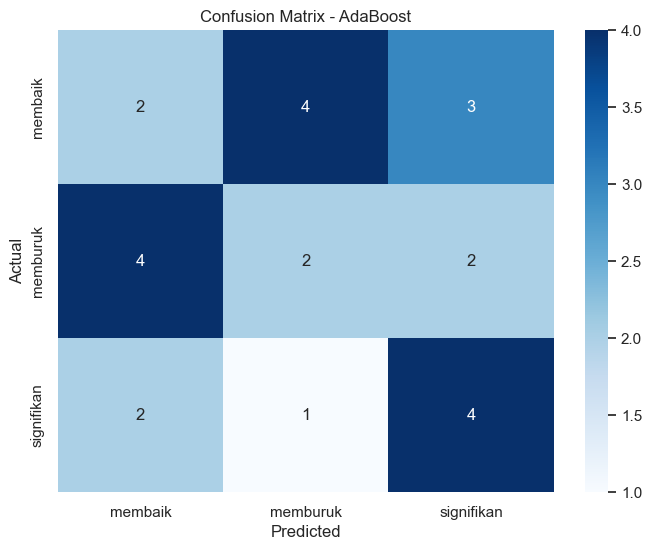

Decision Tree -  3 Classes:
[[3 3 3]
 [3 2 3]
 [3 2 2]]
Macro AUC : 0.4672677404295051
Macro Specificity : 0.6448529411764706
FPR  : [0.0, 0.3125, 0.35294117647058826, 0.4, 1.0]
TPR  : [0.0, 0.2544642857142857, 0.2913165266106443, 0.33881673881673874, 1.0]
              precision    recall  f1-score   support

     membaik       0.33      0.33      0.33         9
    memburuk       0.29      0.25      0.27         8
  signifikan       0.25      0.29      0.27         7

    accuracy                           0.29        24
   macro avg       0.29      0.29      0.29        24
weighted avg       0.29      0.29      0.29        24



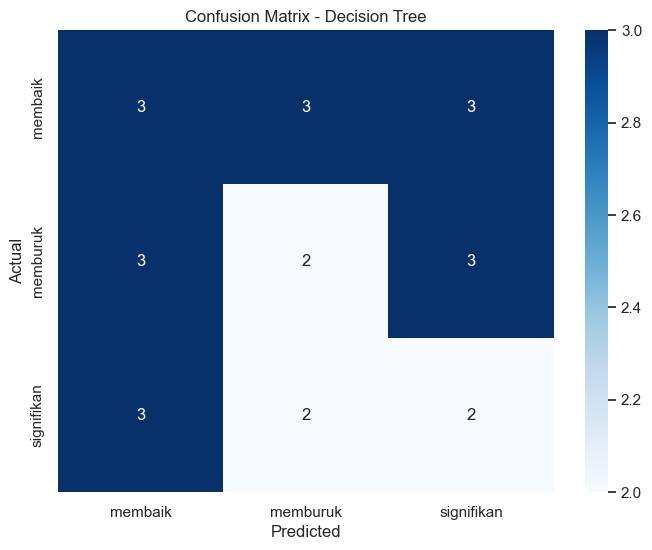

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

Gaussian Process -  3 Classes:
[[9 0 0]
 [8 0 0]
 [6 0 1]]
Macro AUC : 0.5466112602448386
Macro Specificity : 0.6888888888888888
FPR  : [0.0, 0.0625, 0.11764705882352941, 0.13333333333333333, 0.17647058823529413, 0.23529411764705882, 0.26666666666666666, 0.29411764705882354, 0.3125, 0.375, 0.4375, 0.47058823529411764, 0.5625, 0.6, 0.6666666666666666, 0.6875, 0.8, 0.8125, 0.8666666666666667, 0.9333333333333333, 0.9375, 1.0]
TPR  : [0.08465608465608465, 0.08465608465608465, 0.13227513227513227, 0.1693121693121693, 0.2169312169312169, 0.26455026455026454, 0.30158730158730157, 0.3968253968253968, 0.4384920634920635, 0.48015873015873006, 0.5634920634920634, 0.611111111111111, 0.6527777777777778, 0.6898148148148149, 0.7268518518518517, 0.7685185185185185, 0.8425925925925926, 0.8842592592592592, 0.9212962962962963, 0.9583333333333334, 1.0, 1.0]
              precision    recall  f1-score   support

     membaik       0.39      1.00      0.56         9
    memburuk       0.00      0.00      0.

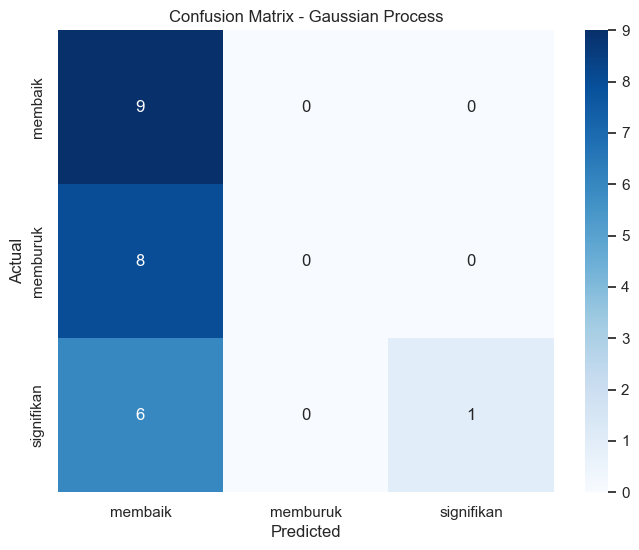

Linear SVM -  3 Classes:
[[9 0 0]
 [8 0 0]
 [7 0 0]]
Macro AUC : 0.4407404165369852
Macro Specificity : 0.6666666666666666
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.1875, 0.2, 0.25, 0.26666666666666666, 0.35294117647058826, 0.5294117647058824, 0.5333333333333333, 0.5625, 0.5882352941176471, 0.6470588235294118, 0.6666666666666666, 0.6875, 0.7058823529411765, 0.75, 0.9411764705882353, 1.0]
TPR  : [0.0, 0.0, 0.0, 0.037037037037037035, 0.12037037037037036, 0.1574074074074074, 0.19907407407407407, 0.23611111111111108, 0.28373015873015867, 0.33134920634920634, 0.4794973544973544, 0.521164021164021, 0.5687830687830687, 0.6164021164021164, 0.6534391534391534, 0.6951058201058201, 0.7427248677248678, 0.8677248677248678, 0.9153439153439153, 1.0]
              precision    recall  f1-score   support

     membaik       0.38      1.00      0.55         9
    memburuk       0.00      0.00      0.00         8
  signifikan       0.00      0.00      0.00         7

    accuracy 

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

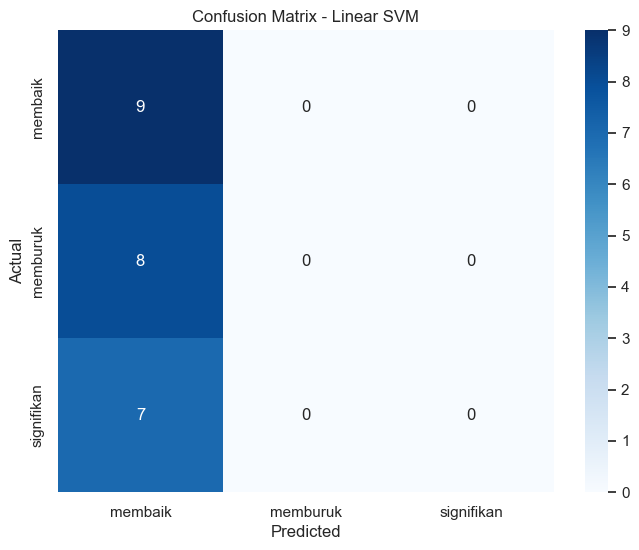

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Multilayer Perceptron -  3 Classes:
[[2 4 3]
 [3 4 1]
 [4 2 1]]
Macro AUC : 0.37157300420168066
Macro Specificity : 0.6410130718954248
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.11764705882352941, 0.1875, 0.25, 0.26666666666666666, 0.29411764705882354, 0.375, 0.4117647058823529, 0.6470588235294118, 0.7058823529411765, 0.75, 0.8, 0.8125, 0.8666666666666667, 0.875, 1.0]
TPR  : [0.0, 0.0, 0.0, 0.0, 0.047619047619047616, 0.08928571428571429, 0.1726190476190476, 0.24669312169312171, 0.2943121693121693, 0.335978835978836, 0.38359788359788355, 0.47883597883597884, 0.5264550264550264, 0.5681216931216931, 0.6051587301587301, 0.6884920634920634, 0.7255291005291005, 0.7671957671957671, 1.0]
              precision    recall  f1-score   support

     membaik       0.22      0.22      0.22         9
    memburuk       0.40      0.50      0.44         8
  signifikan       0.20      0.14      0.17         7

    accuracy                           0.29        24
   macro avg    

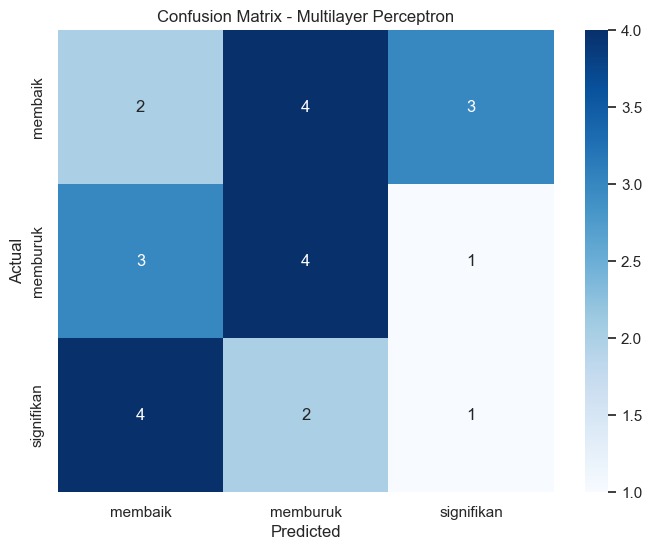

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Naive Bayes -  3 Classes:
[[4 4 1]
 [3 4 1]
 [4 1 2]]
Macro AUC : 0.5246080376595083
Macro Specificity : 0.7010620915032679
FPR  : [0.0, 0.058823529411764705, 0.11764705882352941, 0.13333333333333333, 0.25, 0.4117647058823529, 0.5333333333333333, 0.75, 0.8, 0.8823529411764706, 1.0]
TPR  : [0.0, 0.0457516339869281, 0.18674136321195145, 0.20148148148148148, 0.3219135802469136, 0.43497769478161635, 0.5494708994708994, 0.7635582010582009, 0.8212962962962963, 0.8973311546840957, 1.0]
              precision    recall  f1-score   support

     membaik       0.36      0.44      0.40         9
    memburuk       0.44      0.50      0.47         8
  signifikan       0.50      0.29      0.36         7

    accuracy                           0.42        24
   macro avg       0.44      0.41      0.41        24
weighted avg       0.43      0.42      0.41        24



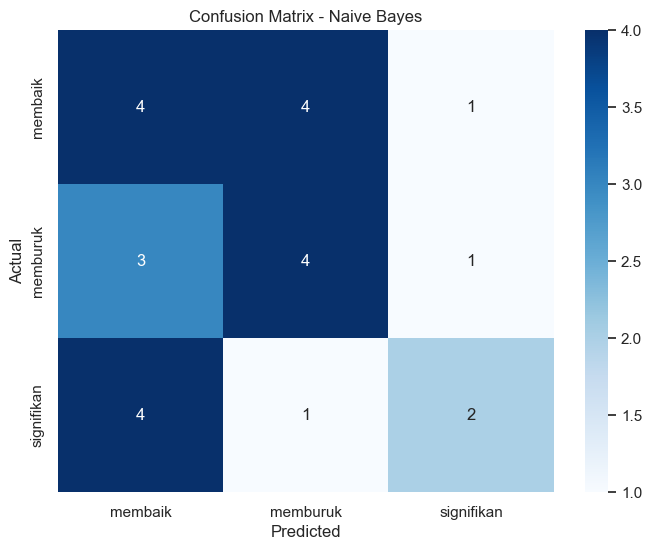

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Nearest Neighbors -  3 Classes:
[[8 1 0]
 [8 0 0]
 [6 0 1]]
Macro AUC : 0.5336747198879551
Macro Specificity : 0.6680555555555555
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.1875, 0.23529411764705882, 0.29411764705882354, 0.3125, 0.3333333333333333, 0.35294117647058826, 0.375, 0.4117647058823529, 0.5, 0.5333333333333333, 0.625, 0.6875, 0.8, 0.8125, 0.8666666666666667, 0.875, 0.9333333333333333, 1.0]
TPR  : [0.08465608465608465, 0.13227513227513227, 0.13227513227513227, 0.1693121693121693, 0.21097883597883596, 0.25859788359788355, 0.3062169312169312, 0.34788359788359785, 0.3849206349206349, 0.4325396825396825, 0.47420634920634913, 0.5694444444444444, 0.611111111111111, 0.6481481481481481, 0.6898148148148149, 0.7314814814814815, 0.7685185185185185, 0.8101851851851851, 0.8472222222222222, 0.8888888888888888, 1.0, 1.0]
              precision    recall  f1-score   support

     membaik       0.36      0.89      0.52         9
    memburuk       0.00      0.00      0.0

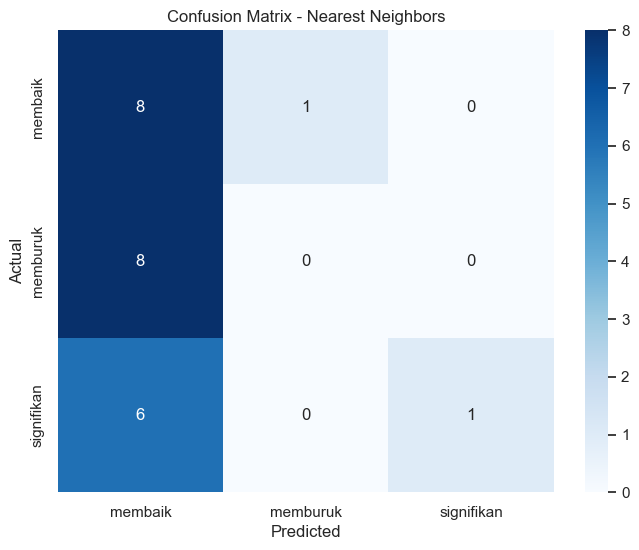

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Quadratic Discriminant Analysis -  3 Classes:
[[3 6 0]
 [2 5 1]
 [5 2 0]]
Macro AUC : 0.4447759427845212
Macro Specificity : 0.6581699346405229
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.2, 0.25, 0.29411764705882354, 0.3125, 0.5, 0.5625, 0.6470588235294118, 0.75, 0.8666666666666667, 0.9333333333333333, 1.0]
TPR  : [0.0, 0.047619047619047616, 0.047619047619047616, 0.12169312169312169, 0.15873015873015872, 0.20039682539682538, 0.29563492063492064, 0.33730158730158727, 0.42063492063492064, 0.503968253968254, 0.6468253968253967, 0.7301587301587301, 0.8783068783068783, 0.9523809523809524, 1.0]
              precision    recall  f1-score   support

     membaik       0.30      0.33      0.32         9
    memburuk       0.38      0.62      0.48         8
  signifikan       0.00      0.00      0.00         7

    accuracy                           0.33        24
   macro avg       0.23      0.32      0.26        24
weighted avg       0.24      0.33      0.28        24



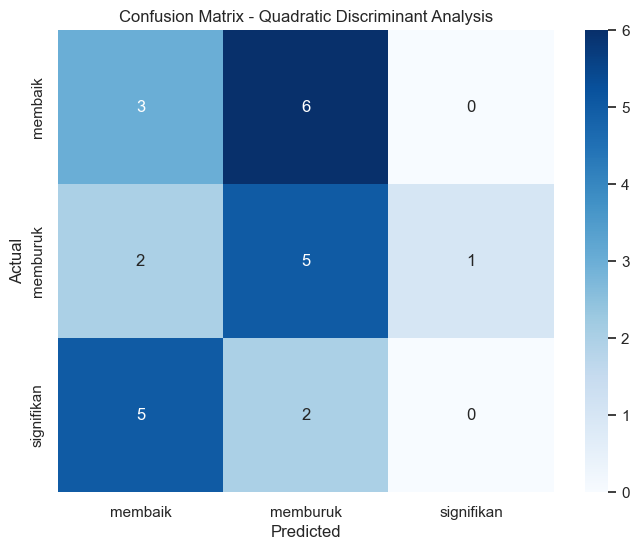

/var/folders/sq/_27zqsss0s304lxljksdbb4r0000gn/T/ipykernel_45662/613309920.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


Random Forest -  3 Classes:
[[3 4 2]
 [5 2 1]
 [4 2 1]]
Macro AUC : 0.45481847831725286
Macro Specificity : 0.6161764705882352
FPR  : [0.0, 0.06666666666666667, 0.1875, 0.35294117647058826, 0.375, 0.4, 0.4117647058823529, 0.4666666666666667, 0.47058823529411764, 0.5, 0.5294117647058824, 0.5625, 0.5882352941176471, 0.6, 0.6666666666666666, 0.6875, 0.7058823529411765, 0.7333333333333333, 0.75, 0.8, 0.8125, 0.8235294117647058, 0.8666666666666667, 0.9411764705882353, 1.0]
TPR  : [0.08928571428571429, 0.1263227513227513, 0.167989417989418, 0.21560846560846558, 0.21560846560846558, 0.26931216931216934, 0.28369125427948955, 0.3952380952380952, 0.4010270774976657, 0.4682539682539682, 0.5158730158730158, 0.5575396825396824, 0.5575396825396824, 0.5575396825396824, 0.5945767195767195, 0.5945767195767195, 0.5945767195767195, 0.7056878306878307, 0.7056878306878307, 0.7723544973544975, 0.7959656084656085, 0.8497121070650482, 0.9107142857142857, 0.9583333333333334, 1.0]
              precision    rec

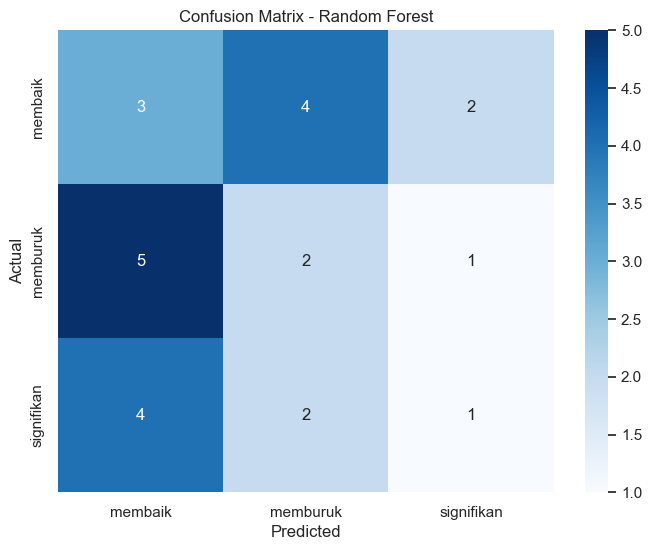

RBF SVM -  3 Classes:
[[7 2 0]
 [7 1 0]
 [7 0 0]]
Macro AUC : 0.4263418793443303
Macro Specificity : 0.6472222222222223
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.125, 0.2, 0.25, 0.35294117647058826, 0.375, 0.4, 0.4117647058823529, 0.625, 0.6470588235294118, 0.6666666666666666, 0.7058823529411765, 0.7333333333333333, 0.7647058823529411, 0.8, 0.875, 1.0]
TPR  : [0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.11574074074074074, 0.1574074074074074, 0.20502645502645503, 0.33002645502645506, 0.40410052910052907, 0.45171957671957674, 0.5350529100529101, 0.5826719576719577, 0.6197089947089948, 0.6673280423280423, 0.7414021164021163, 0.7890211640211641, 0.826058201058201, 0.8677248677248678, 1.0]
              precision    recall  f1-score   support

     membaik       0.33      0.78      0.47         9
    memburuk       0.33      0.12      0.18         8
  signifikan       0.00      0.00      0.00         7

    accuracy                           0.33        24
   macro a

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

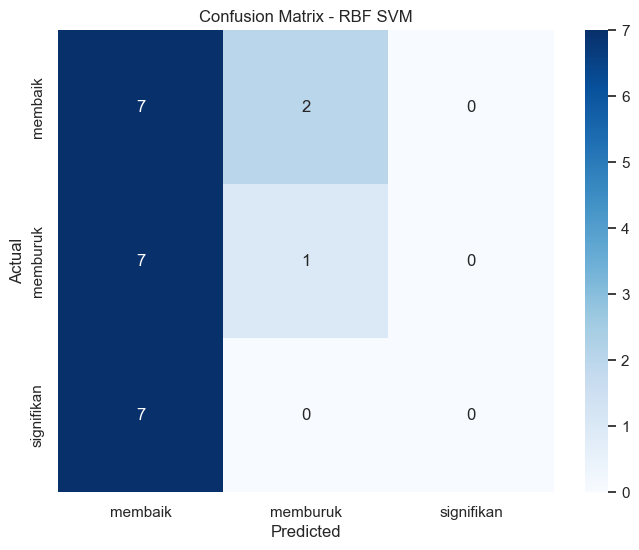

In [57]:
x = pd.concat([x_ct_clinic.iloc[0:33], x_ct_clinic.iloc[57:]])
y = pd.concat([y_3.iloc[0:33], y_3.iloc[57:]])
x_test = x_ct_clinic.iloc[33:57]
y_test = y_3.iloc[33:57]
x_train = x
y_train = y


for name, model in zip(names, classifiers):
    fpr_all = []
    tpr_all = []

    # Train the classifier on the training data
    model.fit(x_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)

    fpr = dict()
    tpr = dict()
    y_test_binarizer = label_binarize(y_test, classes=model.classes_)
    for i in range(len(model.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarizer[:, i], y_pred_proba[:, i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(model.classes_))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(model.classes_)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(model.classes_)

    fpr_all.append(all_fpr)
    tpr_all.append(mean_tpr)

    # Calculate metrics for this fold
    class_report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba, labels=model.classes_, multi_class="ovr", average="macro")
    print(f"{name} -  3 Classes:")
    print(confusion_matrix(y_test, y_pred))
    print(f'Macro AUC : {auc}')
    print(f'Macro Specificity : {specificity_score(y_test, y_pred, labels=model.classes_, average="macro")}')
    print(f'FPR  : {fpr_all[0].tolist()}')
    print(f'TPR  : {tpr_all[0].tolist()}')
    print(class_report)
    # Print heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.savefig(f'images/charts/cf_dataval_ct_clin_3_classes_{name.lower().replace(" ", "_")}.png') 
    plt.show()

### 2 Classes

AdaBoost -  2 Classes:
[[ 3  4]
 [ 4 13]]
Macro AUC : 0.7058823529411765
Macro Specificity : 0.5966386554621849
FPR  : [0.0, 0.14285714285714285, 0.14285714285714285, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0]
TPR  : [0.0, 0.0, 0.7058823529411765, 0.7058823529411765, 0.7647058823529411, 0.7647058823529411, 0.8235294117647058, 0.8235294117647058, 0.9411764705882353, 0.9411764705882353, 1.0, 1.0]
TN, FP, FN, TP : [ 3  4  4 13]
                  precision    recall  f1-score   support

      signifikan       0.43      0.43      0.43         7
tidak signifikan       0.76      0.76      0.76        17

        accuracy                           0.67        24
       macro avg       0.60      0.60      0.60        24
    weighted avg       0.67      0.67      0.67        24



/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


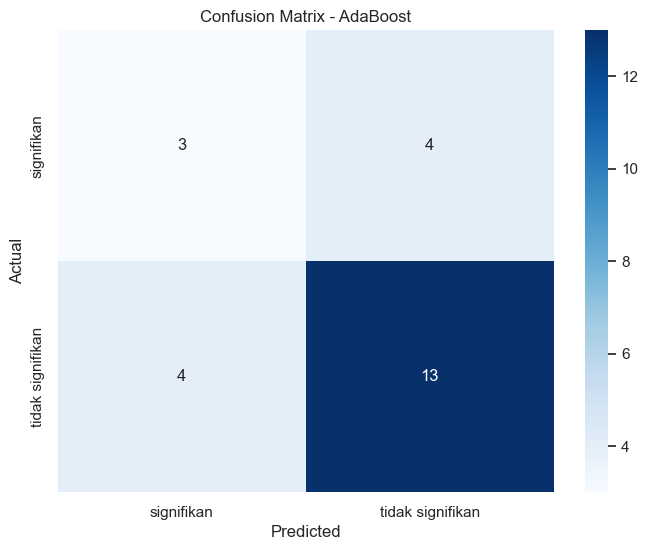

Decision Tree -  2 Classes:
[[5 2]
 [8 9]]
Macro AUC : 0.6218487394957982
Macro Specificity : 0.6218487394957983
FPR  : [0.0, 0.2857142857142857, 1.0]
TPR  : [0.0, 0.5294117647058824, 1.0]
TN, FP, FN, TP : [5 2 8 9]
                  precision    recall  f1-score   support

      signifikan       0.38      0.71      0.50         7
tidak signifikan       0.82      0.53      0.64        17

        accuracy                           0.58        24
       macro avg       0.60      0.62      0.57        24
    weighted avg       0.69      0.58      0.60        24



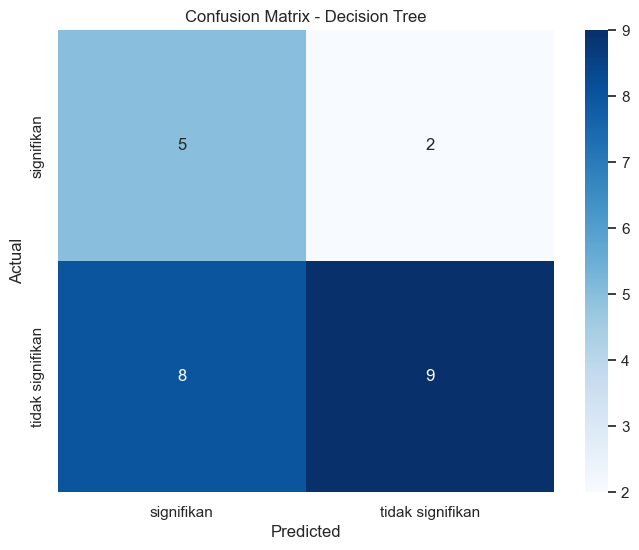

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

Gaussian Process -  2 Classes:
[[ 0  7]
 [ 0 17]]
Macro AUC : 0.773109243697479
Macro Specificity : 0.5
FPR  : [0.0, 0.0, 0.0, 0.2857142857142857, 0.2857142857142857, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0]
TPR  : [0.0, 0.058823529411764705, 0.6470588235294118, 0.6470588235294118, 0.7058823529411765, 0.7058823529411765, 0.8235294117647058, 0.8235294117647058, 0.8823529411764706, 0.8823529411764706, 1.0, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg       0.50      0.71      0.59        24



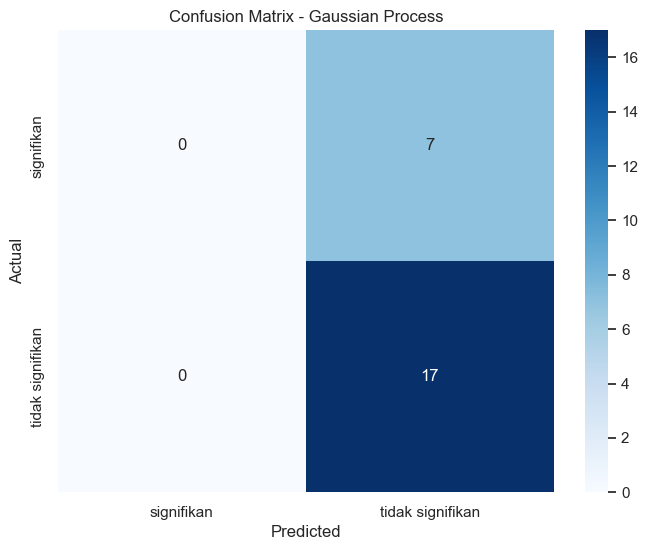

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

Linear SVM -  2 Classes:
[[ 0  7]
 [ 0 17]]
Macro AUC : 0.37815126050420167
Macro Specificity : 0.5
FPR  : [0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0]
TPR  : [0.0, 0.0, 0.11764705882352941, 0.11764705882352941, 0.23529411764705882, 0.23529411764705882, 0.4117647058823529, 0.4117647058823529, 0.5294117647058824, 0.5294117647058824, 0.5882352941176471, 0.5882352941176471, 0.7647058823529411, 0.7647058823529411, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg       0.50      0.71      

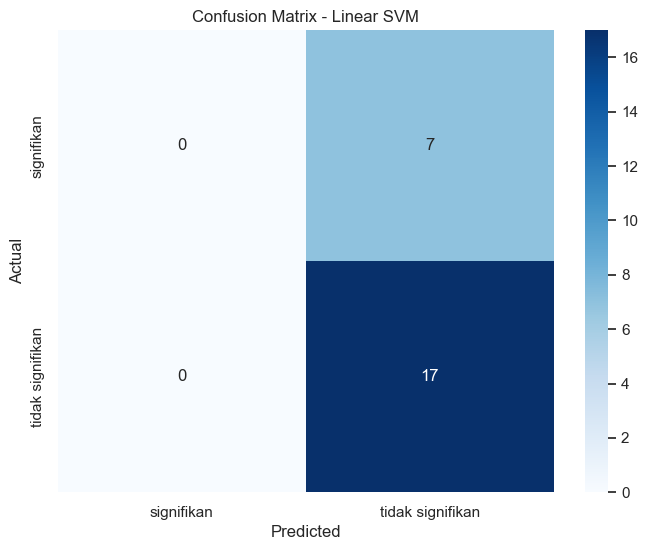

Multilayer Perceptron -  2 Classes:
[[ 1  6]
 [ 2 15]]
Macro AUC : 0.43697478991596644
Macro Specificity : 0.5126050420168067
FPR  : [0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0]
TPR  : [0.0, 0.0, 0.17647058823529413, 0.17647058823529413, 0.29411764705882354, 0.29411764705882354, 0.47058823529411764, 0.47058823529411764, 0.5294117647058824, 0.5294117647058824, 0.7058823529411765, 0.7058823529411765, 0.8823529411764706, 0.8823529411764706, 1.0]
TN, FP, FN, TP : [ 1  6  2 15]
                  precision    recall  f1-score   support

      signifikan       0.33      0.14      0.20         7
tidak signifikan       0.71      0.88      0.79        17

        accuracy                           0.67        24
       macro avg       0.52      0.51      0.49        24
    weighted av

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


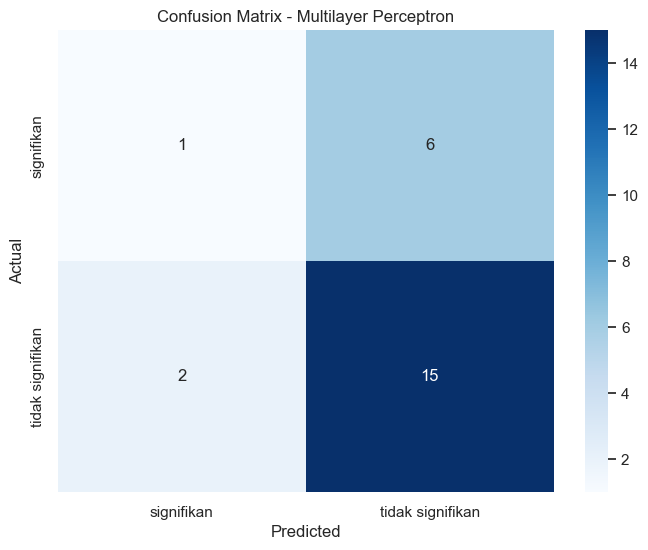

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Naive Bayes -  2 Classes:
[[ 2  5]
 [ 2 15]]
Macro AUC : 0.5672268907563025
Macro Specificity : 0.5840336134453781
FPR  : [0.0, 0.0, 0.5714285714285714, 0.7142857142857143, 1.0, 1.0]
TPR  : [0.0, 0.11764705882352941, 0.5882352941176471, 0.8823529411764706, 0.9411764705882353, 1.0]
TN, FP, FN, TP : [ 2  5  2 15]
                  precision    recall  f1-score   support

      signifikan       0.50      0.29      0.36         7
tidak signifikan       0.75      0.88      0.81        17

        accuracy                           0.71        24
       macro avg       0.62      0.58      0.59        24
    weighted avg       0.68      0.71      0.68        24



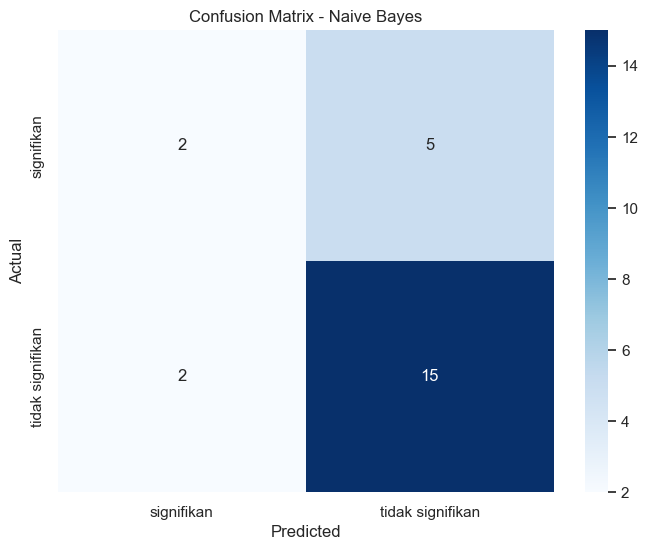

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Nearest Neighbors -  2 Classes:
[[ 0  7]
 [ 0 17]]
Macro AUC : 0.7899159663865547
Macro Specificity : 0.5
FPR  : [0.0, 0.0, 0.0, 0.14285714285714285, 0.14285714285714285, 0.42857142857142855, 0.42857142857142855, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0]
TPR  : [0.0, 0.058823529411764705, 0.17647058823529413, 0.17647058823529413, 0.8235294117647058, 0.8235294117647058, 0.8823529411764706, 0.8823529411764706, 0.9411764705882353, 0.9411764705882353, 1.0, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg       0.50      0.71      0.59        24



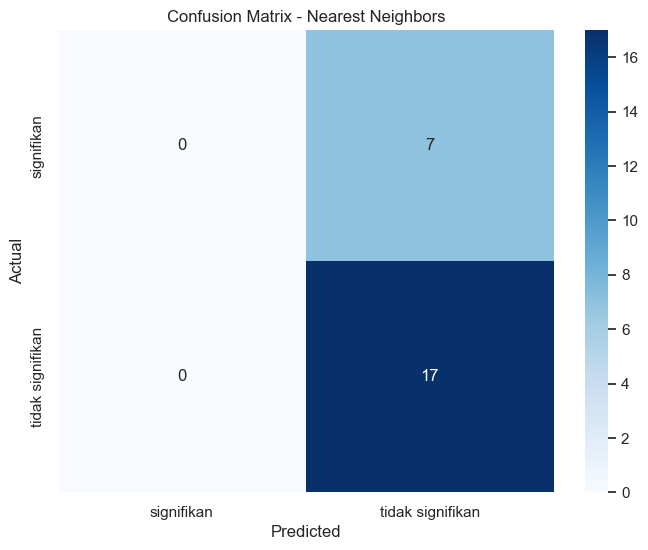

Quadratic Discriminant Analysis -  2 Classes:
[[ 1  6]
 [ 0 17]]
Macro AUC : 0.5966386554621849
Macro Specificity : 0.5714285714285714
FPR  : [0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 1.0]
TPR  : [0.0, 0.0, 0.4117647058823529, 0.4117647058823529, 0.47058823529411764, 0.47058823529411764, 0.5294117647058824, 0.5294117647058824, 0.7647058823529411, 0.7647058823529411, 1.0, 1.0]
TN, FP, FN, TP : [ 1  6  0 17]
                  precision    recall  f1-score   support

      signifikan       1.00      0.14      0.25         7
tidak signifikan       0.74      1.00      0.85        17

        accuracy                           0.75        24
       macro avg       0.87      0.57      0.55        24
    weighted avg       0.82      0.75      0.67        24



/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


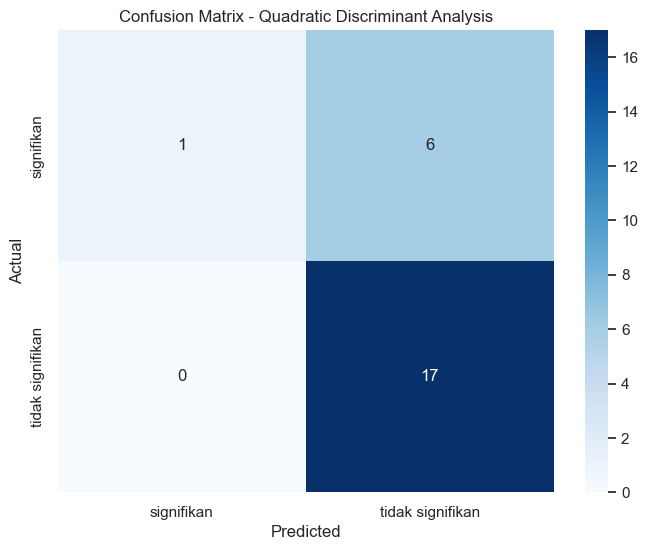

/var/folders/sq/_27zqsss0s304lxljksdbb4r0000gn/T/ipykernel_45662/47336909.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


Random Forest -  2 Classes:
[[ 1  6]
 [ 1 16]]
Macro AUC : 0.6218487394957983
Macro Specificity : 0.542016806722689
FPR  : [0.0, 0.0, 0.0, 0.14285714285714285, 0.2857142857142857, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.8571428571428571, 0.8571428571428571, 1.0]
TPR  : [0.0, 0.058823529411764705, 0.4117647058823529, 0.47058823529411764, 0.47058823529411764, 0.5294117647058824, 0.5294117647058824, 0.6470588235294118, 0.7058823529411765, 0.7058823529411765, 1.0, 1.0]
TN, FP, FN, TP : [ 1  6  1 16]
                  precision    recall  f1-score   support

      signifikan       0.50      0.14      0.22         7
tidak signifikan       0.73      0.94      0.82        17

        accuracy                           0.71        24
       macro avg       0.61      0.54      0.52        24
    weighted avg       0.66      0.71      0.65        24



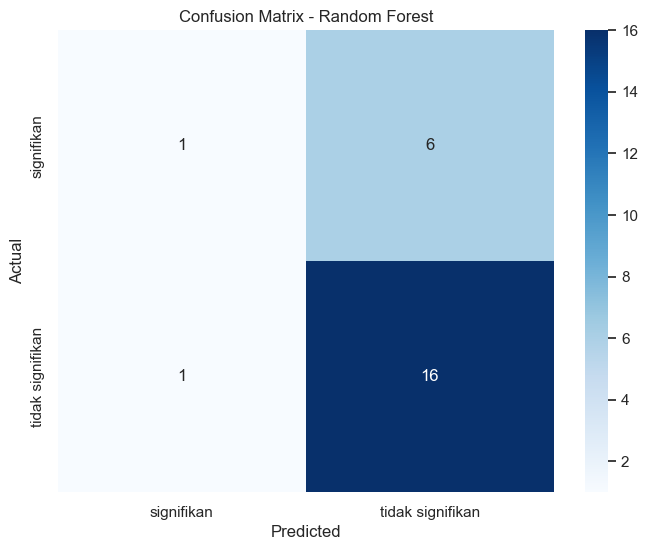

RBF SVM -  2 Classes:
[[ 0  7]
 [ 0 17]]
Macro AUC : 0.4705882352941177
Macro Specificity : 0.5
FPR  : [0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0]
TPR  : [0.0, 0.0, 0.11764705882352941, 0.11764705882352941, 0.17647058823529413, 0.17647058823529413, 0.47058823529411764, 0.47058823529411764, 0.8235294117647058, 0.8235294117647058, 0.8823529411764706, 0.8823529411764706, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg       0.50      0.71      0.59        24



/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

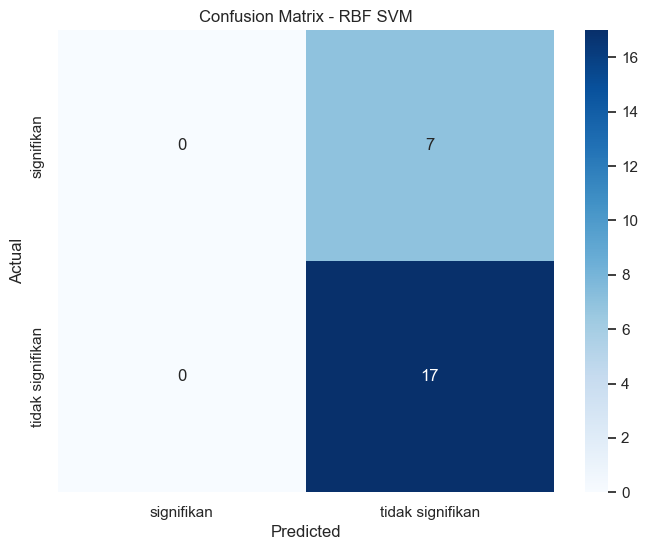

In [58]:
x = pd.concat([x_ct_clinic.iloc[0:33], x_ct_clinic.iloc[57:]])
y = pd.concat([y_2.iloc[0:33], y_2.iloc[57:]])
x_test = x_ct_clinic.iloc[33:57]
y_test = y_2.iloc[33:57]
x_train = x
y_train = y

for name, model in zip(names, classifiers):
    fpr_all = []
    tpr_all = []

    # Train the classifier on the training data
    model.fit(x_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)

    y_test_binarizer = label_binarize(y_test, classes=model.classes_)
    fpr, tpr, _ = roc_curve(y_test_binarizer, y_pred_proba[:, 1])

    fpr_all.append(fpr)
    tpr_all.append(tpr)

    # Calculate metrics for this fold
    class_report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba[:,1])

    print(f"{name} -  2 Classes:")
    print(confusion_matrix(y_test, y_pred))
    print(f'Macro AUC : {auc}')
    print(f'Macro Specificity : {specificity_score(y_test, y_pred, labels=model.classes_, average="macro")}')
    print(f'FPR  : {fpr_all[0].tolist()}')
    print(f'TPR  : {tpr_all[0].tolist()}')
    print(f'TN, FP, FN, TP : {confusion_matrix(y_test, y_pred).ravel()}')
    print(class_report)
    # Print heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.savefig(f'images/charts/cf_dataval_ct_clin_2_classes_{name.lower().replace(" ", "_")}.png') 
    plt.show()


## CT + Klinis + Lab

### 3 Classes

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost -  3 Classes:
[[5 3 1]
 [6 0 2]
 [3 0 4]]
Macro AUC : 0.6261139641041602
Macro Specificity : 0.6786764705882353
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.13333333333333333, 0.17647058823529413, 0.3125, 0.3333333333333333, 0.375, 0.4375, 0.4666666666666667, 0.5, 0.625, 0.6666666666666666, 0.7333333333333333, 0.9333333333333333, 1.0]
TPR  : [0.0, 0.2380952380952381, 0.2380952380952381, 0.2380952380952381, 0.2751322751322751, 0.32275132275132273, 0.36441798941798936, 0.5125661375661376, 0.5958994708994708, 0.7208994708994708, 0.7579365079365079, 0.7996031746031745, 0.8412698412698413, 0.8783068783068783, 0.9153439153439153, 0.9523809523809524, 1.0]
TN, FP, FN, TP : [5 3 1 6 0 2 3 0 4]
              precision    recall  f1-score   support

     membaik       0.36      0.56      0.43         9
    memburuk       0.00      0.00      0.00         8
  signifikan       0.57      0.57      0.57         7

    accuracy                           0.38        24
   m

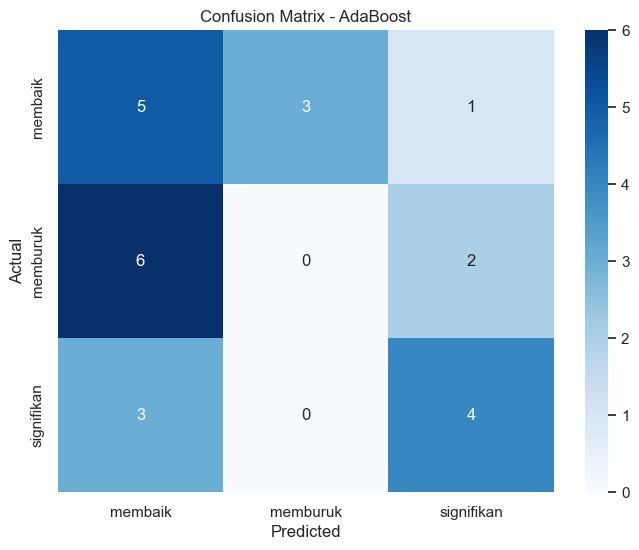

Decision Tree -  3 Classes:
[[1 5 3]
 [3 3 2]
 [2 1 4]]
Macro AUC : 0.509181450357921
Macro Specificity : 0.6658496732026143
FPR  : [0.0, 0.29411764705882354, 0.3333333333333333, 0.375, 1.0]
TPR  : [0.0, 0.32119514472455646, 0.3465608465608465, 0.38740079365079366, 1.0]
TN, FP, FN, TP : [1 5 3 3 3 2 2 1 4]
              precision    recall  f1-score   support

     membaik       0.17      0.11      0.13         9
    memburuk       0.33      0.38      0.35         8
  signifikan       0.44      0.57      0.50         7

    accuracy                           0.33        24
   macro avg       0.31      0.35      0.33        24
weighted avg       0.30      0.33      0.31        24



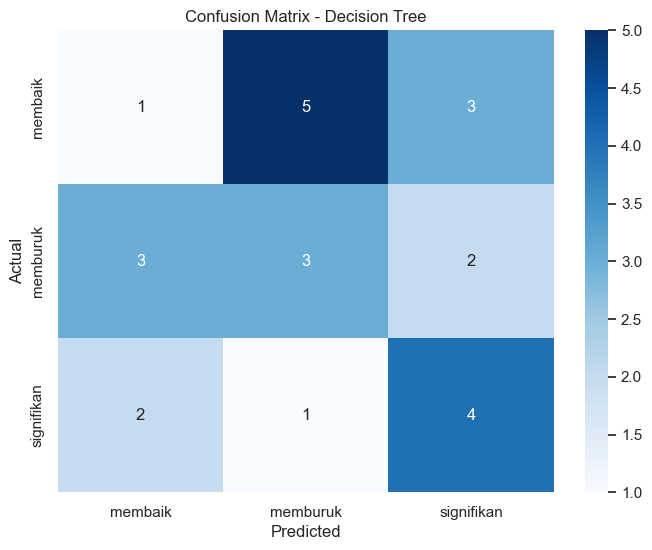

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

Gaussian Process -  3 Classes:
[[9 0 0]
 [8 0 0]
 [6 0 1]]
Macro AUC : 0.6021475256769374
Macro Specificity : 0.6888888888888888
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.11764705882352941, 0.35294117647058826, 0.4666666666666667, 0.47058823529411764, 0.5294117647058824, 0.5625, 0.6875, 0.7333333333333333, 0.8125, 0.8666666666666667, 0.9333333333333333, 1.0]
TPR  : [0.047619047619047616, 0.14285714285714285, 0.2261904761904762, 0.37433862433862436, 0.4219576719576719, 0.46957671957671954, 0.5066137566137566, 0.5542328042328042, 0.6018518518518519, 0.7268518518518517, 0.8101851851851851, 0.8472222222222222, 0.8888888888888888, 0.9259259259259259, 1.0, 1.0]
TN, FP, FN, TP : [9 0 0 8 0 0 6 0 1]
              precision    recall  f1-score   support

     membaik       0.39      1.00      0.56         9
    memburuk       0.00      0.00      0.00         8
  signifikan       1.00      0.14      0.25         7

    accuracy                           0.42        24
   

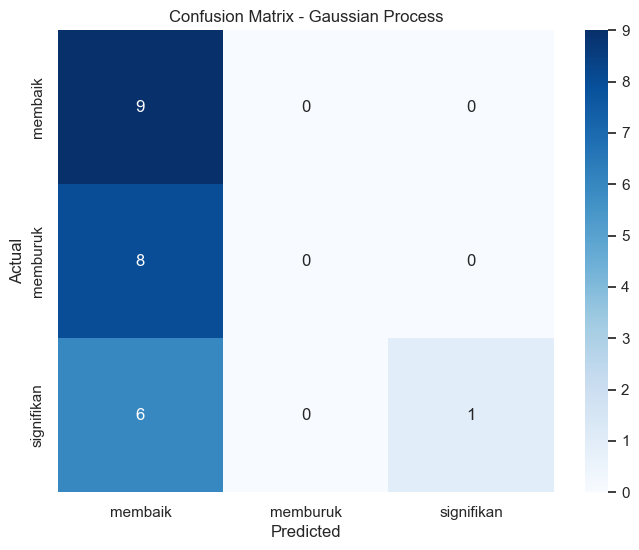

Linear SVM -  3 Classes:
[[9 0 0]
 [8 0 0]
 [7 0 0]]
Macro AUC : 0.6100443186533873
Macro Specificity : 0.6666666666666666
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.125, 0.13333333333333333, 0.25, 0.4, 0.47058823529411764, 0.5625, 0.5882352941176471, 0.625, 0.9333333333333333, 1.0]
TPR  : [0.09523809523809523, 0.19047619047619047, 0.23214285714285712, 0.3062169312169312, 0.34788359788359785, 0.4219576719576719, 0.4636243386243386, 0.5006613756613757, 0.5482804232804233, 0.7149470899470899, 0.8101851851851851, 0.8518518518518517, 1.0, 1.0]
TN, FP, FN, TP : [9 0 0 8 0 0 7 0 0]
              precision    recall  f1-score   support

     membaik       0.38      1.00      0.55         9
    memburuk       0.00      0.00      0.00         8
  signifikan       0.00      0.00      0.00         7

    accuracy                           0.38        24
   macro avg       0.12      0.33      0.18        24
weighted avg       0.14      0.38      0.20        24



/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

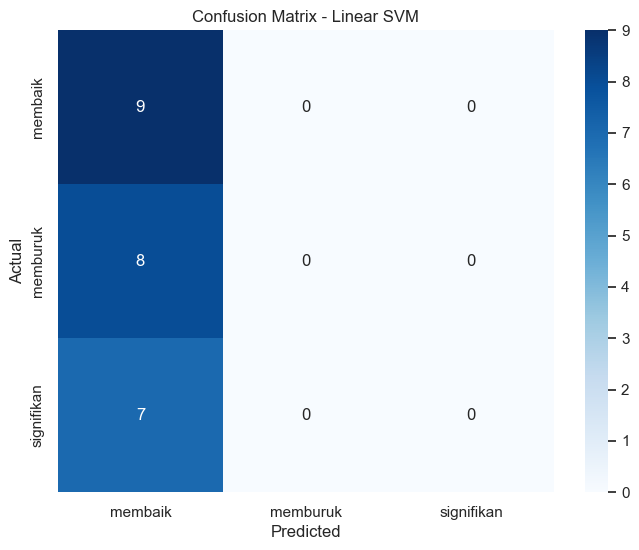

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Multilayer Perceptron -  3 Classes:
[[4 5 0]
 [3 5 0]
 [5 1 1]]
Macro AUC : 0.5516054569976139
Macro Specificity : 0.6972222222222223
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.125, 0.17647058823529413, 0.25, 0.26666666666666666, 0.3125, 0.3333333333333333, 0.375, 0.4666666666666667, 0.625, 0.75, 0.7647058823529411, 0.8, 0.8666666666666667, 0.9411764705882353, 1.0]
TPR  : [0.047619047619047616, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.18452380952380953, 0.27976190476190477, 0.36309523809523814, 0.4001322751322751, 0.48346560846560854, 0.5575396825396824, 0.5992063492063492, 0.6362433862433862, 0.6779100529100529, 0.7195767195767195, 0.7671957671957671, 0.8042328042328042, 0.8783068783068783, 0.9259259259259259, 1.0]
TN, FP, FN, TP : [4 5 0 3 5 0 5 1 1]
              precision    recall  f1-score   support

     membaik       0.33      0.44      0.38         9
    memburuk       0.45      0.62      0.53         8
  signifikan       1.00    

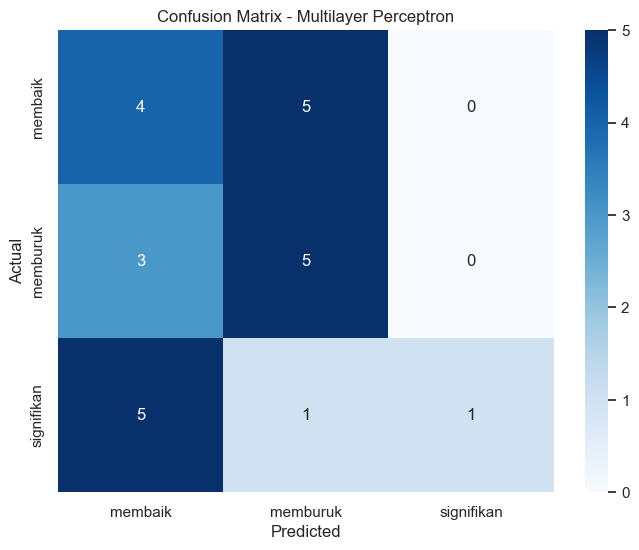

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Naive Bayes -  3 Classes:
[[5 3 1]
 [3 4 1]
 [4 2 1]]
Macro AUC : 0.5831372711121485
Macro Specificity : 0.7010620915032679
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.11764705882352941, 0.2, 0.23529411764705882, 0.25, 0.6, 0.625, 0.7058823529411765, 0.9333333333333333, 0.9375, 1.0]
TPR  : [0.0, 0.0, 0.0029761904761904765, 0.010052910052910051, 0.1391223155929038, 0.34761904761904755, 0.42063492063492064, 0.4436177248677248, 0.7183862433862434, 0.7315310846560846, 0.7866402116402117, 0.9093915343915343, 0.9134920634920635, 1.0]
TN, FP, FN, TP : [5 3 1 3 4 1 4 2 1]
              precision    recall  f1-score   support

     membaik       0.42      0.56      0.48         9
    memburuk       0.44      0.50      0.47         8
  signifikan       0.33      0.14      0.20         7

    accuracy                           0.42        24
   macro avg       0.40      0.40      0.38        24
weighted avg       0.40      0.42      0.39        24



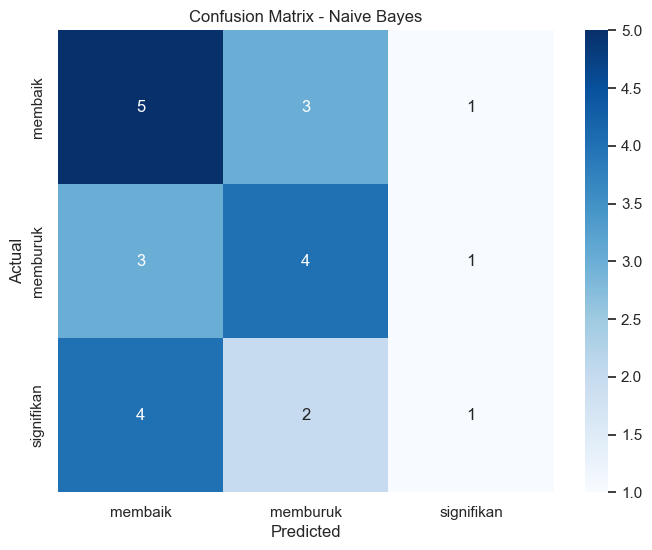

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Nearest Neighbors -  3 Classes:
[[6 3 0]
 [6 2 0]
 [6 0 1]]
Macro AUC : 0.5561050809212574
Macro Specificity : 0.6708333333333334
FPR  : [0.0, 0.0625, 0.06666666666666667, 0.11764705882352941, 0.13333333333333333, 0.1875, 0.3333333333333333, 0.4117647058823529, 0.5294117647058824, 0.5625, 0.625, 0.6470588235294118, 0.7333333333333333, 0.8125, 0.9333333333333333, 1.0]
TPR  : [0.13227513227513227, 0.13227513227513227, 0.1693121693121693, 0.26455026455026454, 0.30158730158730157, 0.3849206349206349, 0.4219576719576719, 0.46957671957671954, 0.5171957671957671, 0.6421957671957671, 0.7255291005291005, 0.7731481481481483, 0.8101851851851851, 0.8518518518518517, 1.0, 1.0]
TN, FP, FN, TP : [6 3 0 6 2 0 6 0 1]
              precision    recall  f1-score   support

     membaik       0.33      0.67      0.44         9
    memburuk       0.40      0.25      0.31         8
  signifikan       1.00      0.14      0.25         7

    accuracy                           0.38        24
   macro avg      

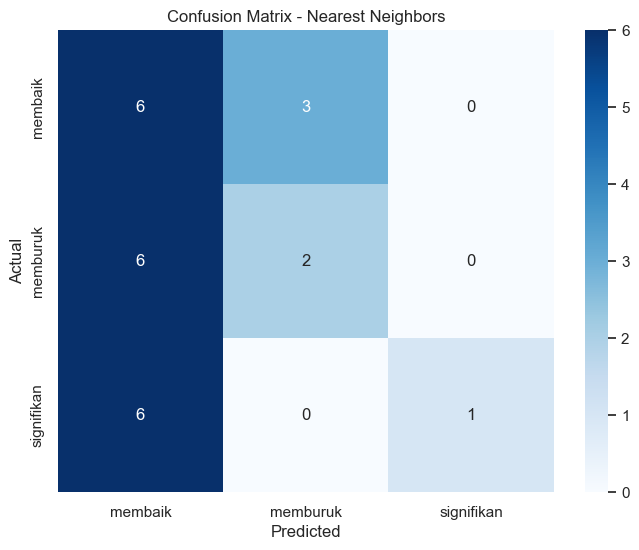

Quadratic Discriminant Analysis -  3 Classes:
[[4 5 0]
 [3 5 0]
 [3 1 3]]
Macro AUC : 0.5723353693329184
Macro Specificity : 0.7416666666666667
FPR  : [0.0, 0.0625, 0.06666666666666667, 0.13333333333333333, 0.1875, 0.26666666666666666, 0.3125, 0.4375, 0.5625, 0.5882352941176471, 0.6, 0.7058823529411765, 0.8, 0.8235294117647058, 0.8666666666666667, 1.0]
TPR  : [0.14285714285714285, 0.2261904761904762, 0.2261904761904762, 0.30026455026455023, 0.3419312169312169, 0.416005291005291, 0.49933862433862436, 0.5826719576719577, 0.6243386243386243, 0.671957671957672, 0.708994708994709, 0.7566137566137566, 0.8306878306878307, 0.8783068783068783, 0.9153439153439153, 1.0]
TN, FP, FN, TP : [4 5 0 3 5 0 3 1 3]
              precision    recall  f1-score   support

     membaik       0.40      0.44      0.42         9
    memburuk       0.45      0.62      0.53         8
  signifikan       1.00      0.43      0.60         7

    accuracy                           0.50        24
   macro avg       0.62

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


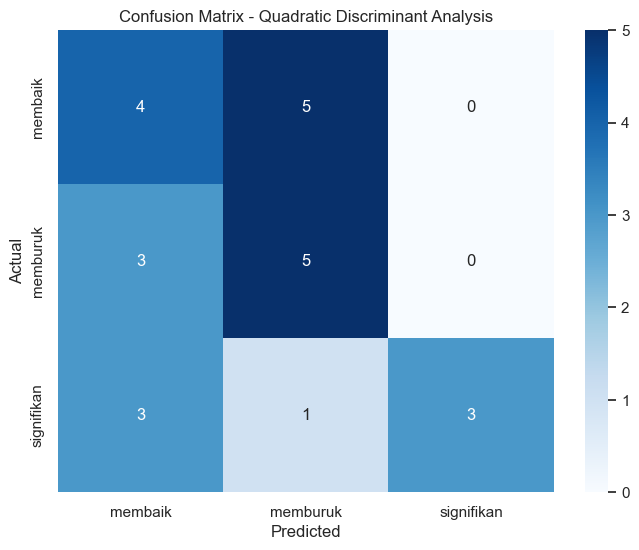

/var/folders/sq/_27zqsss0s304lxljksdbb4r0000gn/T/ipykernel_36040/298127489.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


Random Forest -  3 Classes:
[[2 5 2]
 [3 5 0]
 [1 2 4]]
Macro AUC : 0.5118023945689387
Macro Specificity : 0.726062091503268
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.11764705882352941, 0.125, 0.1875, 0.2, 0.23529411764705882, 0.25, 0.26666666666666666, 0.3333333333333333, 0.375, 0.4117647058823529, 0.4666666666666667, 0.47058823529411764, 0.5882352941176471, 0.6, 0.6666666666666666, 0.6875, 0.7058823529411765, 0.75, 0.7647058823529411, 0.8, 0.8235294117647058, 0.8666666666666667, 0.9333333333333333, 1.0]
TPR  : [0.047619047619047616, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.19047619047619047, 0.19047619047619047, 0.2738095238095238, 0.31084656084656087, 0.31084656084656087, 0.3525132275132275, 0.3525132275132275, 0.3895502645502645, 0.47288359788359785, 0.47288359788359785, 0.47288359788359785, 0.4739729225023342, 0.5066526610644257, 0.5099206349206349, 0.6210317460317459, 0.7043650793650794, 0.7043650793650794, 0.7817460317460316, 0.841

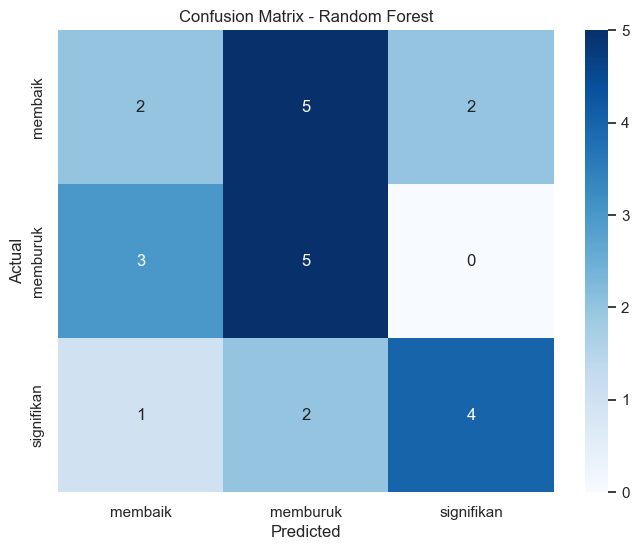

RBF SVM -  3 Classes:
[[6 3 0]
 [6 2 0]
 [5 2 0]]
Macro AUC : 0.549197271501193
Macro Specificity : 0.6513888888888889
FPR  : [0.0, 0.058823529411764705, 0.0625, 0.06666666666666667, 0.2, 0.26666666666666666, 0.29411764705882354, 0.3333333333333333, 0.4, 0.4666666666666667, 0.5, 0.5882352941176471, 0.6875, 0.7058823529411765, 0.7333333333333333, 0.7647058823529411, 0.8666666666666667, 1.0]
TPR  : [0.09523809523809523, 0.14285714285714285, 0.2261904761904762, 0.2261904761904762, 0.2632275132275132, 0.30026455026455023, 0.34788359788359785, 0.3849206349206349, 0.4219576719576719, 0.458994708994709, 0.6256613756613757, 0.6732804232804233, 0.7566137566137566, 0.8042328042328042, 0.8412698412698413, 0.8888888888888888, 0.9629629629629629, 1.0]
TN, FP, FN, TP : [6 3 0 6 2 0 5 2 0]
              precision    recall  f1-score   support

     membaik       0.35      0.67      0.46         9
    memburuk       0.29      0.25      0.27         8
  signifikan       0.00      0.00      0.00        

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

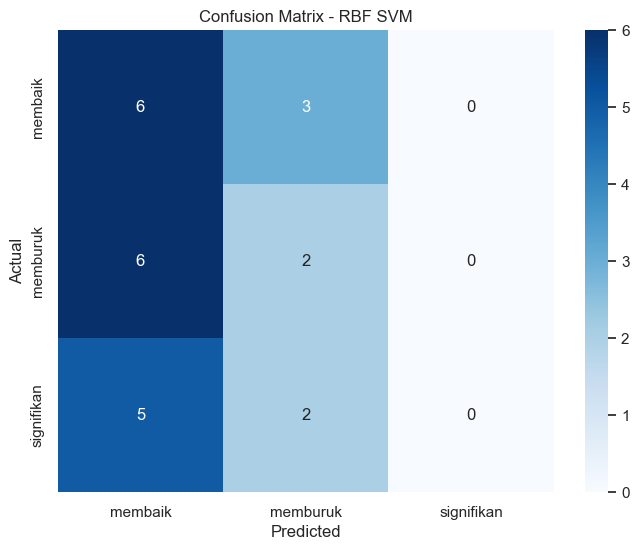

In [12]:
x = pd.concat([x_ct_clinic_lab.iloc[0:33], x_ct_clinic_lab.iloc[57:]])
y = pd.concat([y_3.iloc[0:33], y_3.iloc[57:]])
x_test = x_ct_clinic_lab.iloc[33:57]
y_test = y_3.iloc[33:57]
x_train = x
y_train = y

for name, model in zip(names, classifiers):
    fpr_all = []
    tpr_all = []

    # Train the classifier on the training data
    model.fit(x_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)

    fpr = dict()
    tpr = dict()
    y_test_binarizer = label_binarize(y_test, classes=model.classes_)
    for i in range(len(model.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarizer[:, i], y_pred_proba[:, i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(model.classes_))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(model.classes_)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(model.classes_)

    fpr_all.append(all_fpr)
    tpr_all.append(mean_tpr)

    # Calculate metrics for this fold
    class_report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba, labels=model.classes_, multi_class="ovr", average="macro")
    print(f"{name} -  3 Classes:")
    print(confusion_matrix(y_test, y_pred))
    print(f'Macro AUC : {auc}')
    print(f'Macro Specificity : {specificity_score(y_test, y_pred, labels=model.classes_, average="macro")}')
    print(f'FPR  : {fpr_all[0].tolist()}')
    print(f'TPR  : {tpr_all[0].tolist()}')
    print(f'TN, FP, FN, TP : {confusion_matrix(y_test, y_pred).ravel()}')
    print(class_report)
    # Print heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.savefig(f'images/charts/cf_dataval_ct_clin_lab_3_classes_{name.lower().replace(" ", "_")}.png') 
    plt.show()

### 2 Classes

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost -  2 Classes:
[[ 3  4]
 [ 3 14]]
Macro AUC : 0.6134453781512605
Macro Specificity : 0.6260504201680672
FPR  : [0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 0.8571428571428571, 0.8571428571428571, 1.0]
TPR  : [0.0, 0.0, 0.29411764705882354, 0.29411764705882354, 0.5882352941176471, 0.5882352941176471, 0.6470588235294118, 0.6470588235294118, 0.8235294117647058, 0.8235294117647058, 0.9411764705882353, 0.9411764705882353, 1.0, 1.0]
TN, FP, FN, TP : [ 3  4  3 14]
                  precision    recall  f1-score   support

      signifikan       0.50      0.43      0.46         7
tidak signifikan       0.78      0.82      0.80        17

        accuracy                           0.71        24
       macro avg       0.64      0.63      0.63        24
    weighted avg       0.70      0.71      0.70        24



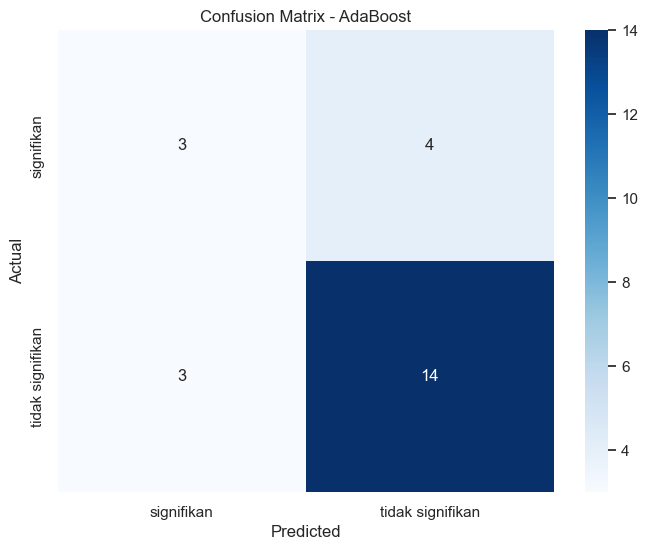

Decision Tree -  2 Classes:
[[ 3  4]
 [ 6 11]]
Macro AUC : 0.5378151260504203
Macro Specificity : 0.5378151260504201
FPR  : [0.0, 0.5714285714285714, 1.0]
TPR  : [0.0, 0.6470588235294118, 1.0]
TN, FP, FN, TP : [ 3  4  6 11]
                  precision    recall  f1-score   support

      signifikan       0.33      0.43      0.38         7
tidak signifikan       0.73      0.65      0.69        17

        accuracy                           0.58        24
       macro avg       0.53      0.54      0.53        24
    weighted avg       0.62      0.58      0.60        24



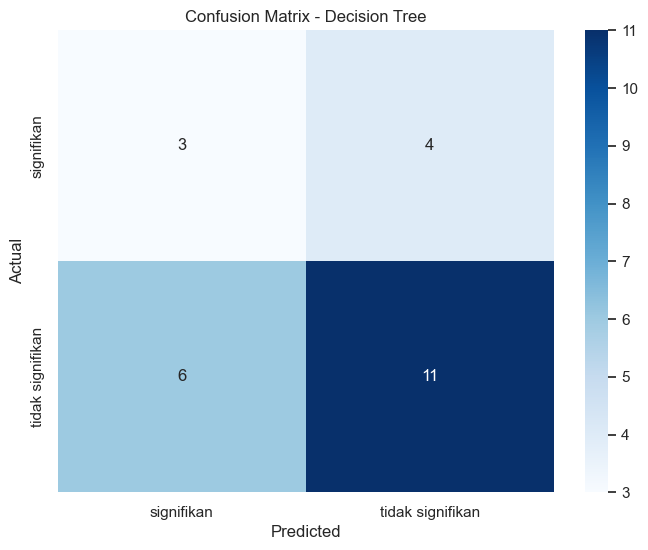

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

Gaussian Process -  2 Classes:
[[ 0  7]
 [ 0 17]]
Macro AUC : 0.7815126050420168
Macro Specificity : 0.5
FPR  : [0.0, 0.0, 0.0, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.8571428571428571, 0.8571428571428571, 1.0]
TPR  : [0.0, 0.058823529411764705, 0.5294117647058824, 0.5294117647058824, 0.6470588235294118, 0.6470588235294118, 0.8823529411764706, 0.8823529411764706, 0.9411764705882353, 0.9411764705882353, 1.0, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg       0.50      0.71      0.59        24



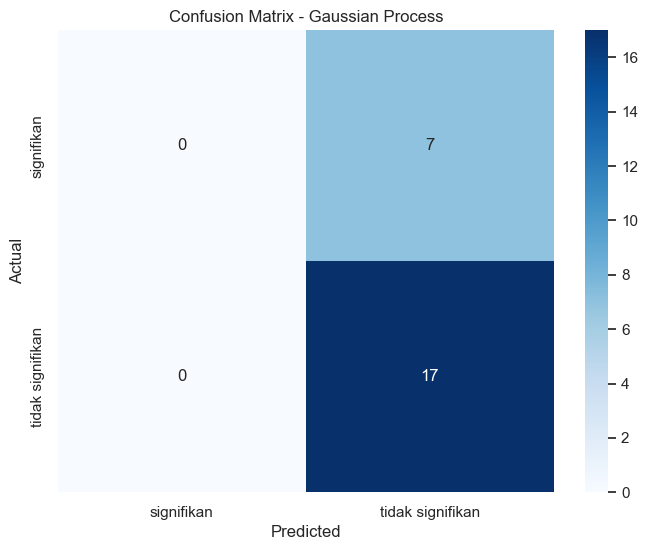

Linear SVM -  2 Classes:
[[ 0  7]
 [ 0 17]]
Macro AUC : 0.7899159663865546
Macro Specificity : 0.5
FPR  : [0.0, 0.0, 0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 1.0]
TPR  : [0.0, 0.058823529411764705, 0.23529411764705882, 0.23529411764705882, 0.47058823529411764, 0.47058823529411764, 0.8823529411764706, 0.8823529411764706, 0.9411764705882353, 0.9411764705882353, 1.0, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg       0.50      0.71      0.59        24



/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

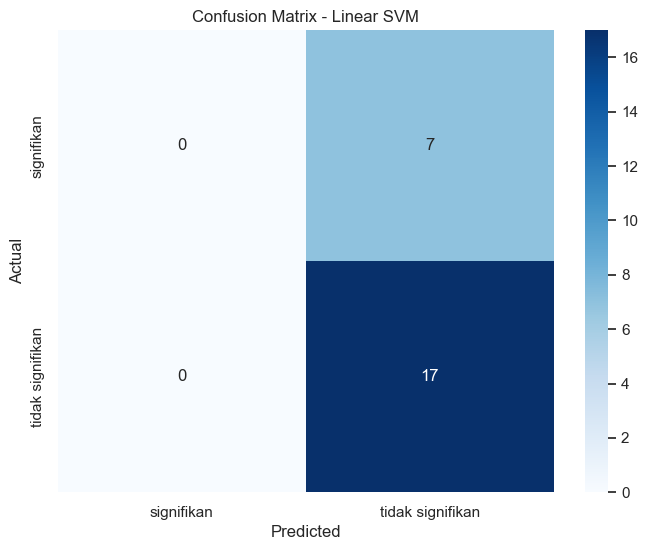

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Multilayer Perceptron -  2 Classes:
[[ 1  6]
 [ 1 16]]
Macro AUC : 0.6554621848739496
Macro Specificity : 0.542016806722689
FPR  : [0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.8571428571428571, 0.8571428571428571, 1.0]
TPR  : [0.0, 0.0, 0.11764705882352941, 0.11764705882352941, 0.7647058823529411, 0.7647058823529411, 0.8235294117647058, 0.8235294117647058, 0.9411764705882353, 0.9411764705882353, 1.0, 1.0]
TN, FP, FN, TP : [ 1  6  1 16]
                  precision    recall  f1-score   support

      signifikan       0.50      0.14      0.22         7
tidak signifikan       0.73      0.94      0.82        17

        accuracy                           0.71        24
       macro avg       0.61      0.54      0.52        24
    weighted avg       0.66      0.71      0.65        24



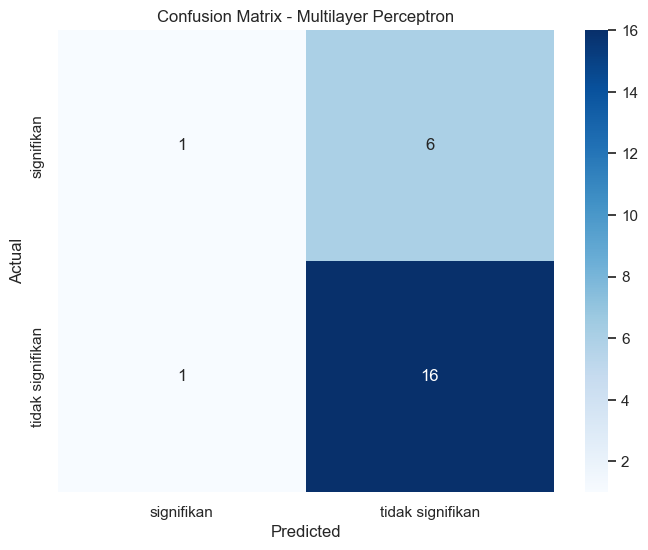

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Naive Bayes -  2 Classes:
[[ 1  6]
 [ 2 15]]
Macro AUC : 0.6134453781512605
Macro Specificity : 0.5126050420168067
FPR  : [0.0, 0.14285714285714285, 0.5714285714285714, 0.8571428571428571, 1.0, 1.0]
TPR  : [0.0, 0.29411764705882354, 0.7647058823529411, 0.8823529411764706, 0.9411764705882353, 1.0]
TN, FP, FN, TP : [ 1  6  2 15]
                  precision    recall  f1-score   support

      signifikan       0.33      0.14      0.20         7
tidak signifikan       0.71      0.88      0.79        17

        accuracy                           0.67        24
       macro avg       0.52      0.51      0.49        24
    weighted avg       0.60      0.67      0.62        24



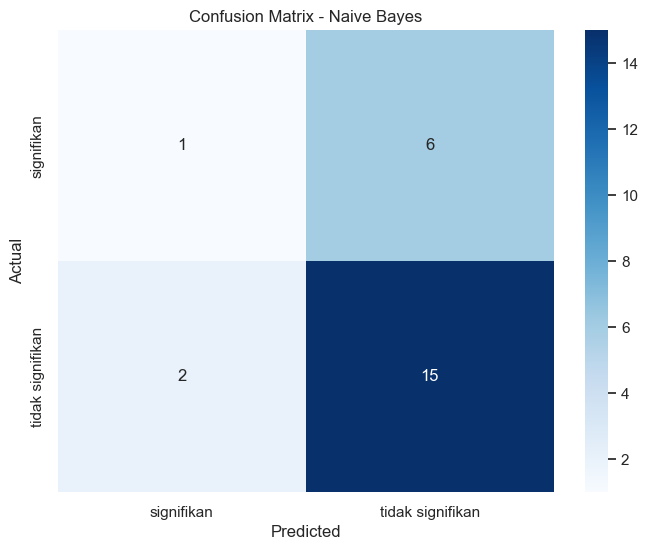

/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Nearest Neighbors -  2 Classes:
[[ 0  7]
 [ 0 17]]
Macro AUC : 0.8067226890756302
Macro Specificity : 0.5
FPR  : [0.0, 0.0, 0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.5714285714285714, 0.5714285714285714, 0.8571428571428571, 0.8571428571428571, 1.0]
TPR  : [0.0, 0.058823529411764705, 0.47058823529411764, 0.47058823529411764, 0.6470588235294118, 0.6470588235294118, 0.8235294117647058, 0.8235294117647058, 0.9411764705882353, 0.9411764705882353, 1.0, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg       0.50      0.71      0.59        24



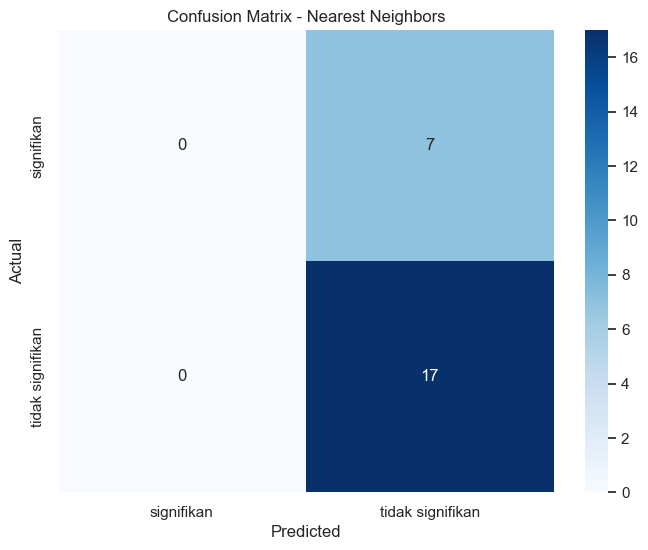

Quadratic Discriminant Analysis -  2 Classes:
[[ 2  5]
 [ 0 17]]
Macro AUC : 0.5798319327731093
Macro Specificity : 0.6428571428571428
FPR  : [0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 1.0]
TPR  : [0.0, 0.0, 0.23529411764705882, 0.23529411764705882, 0.35294117647058826, 0.35294117647058826, 0.5294117647058824, 0.5294117647058824, 0.9411764705882353, 0.9411764705882353, 1.0, 1.0]
TN, FP, FN, TP : [ 2  5  0 17]
                  precision    recall  f1-score   support

      signifikan       1.00      0.29      0.44         7
tidak signifikan       0.77      1.00      0.87        17

        accuracy                           0.79        24
       macro avg       0.89      0.64      0.66        24
    weighted avg       0.84      0.79      0.75        24



/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


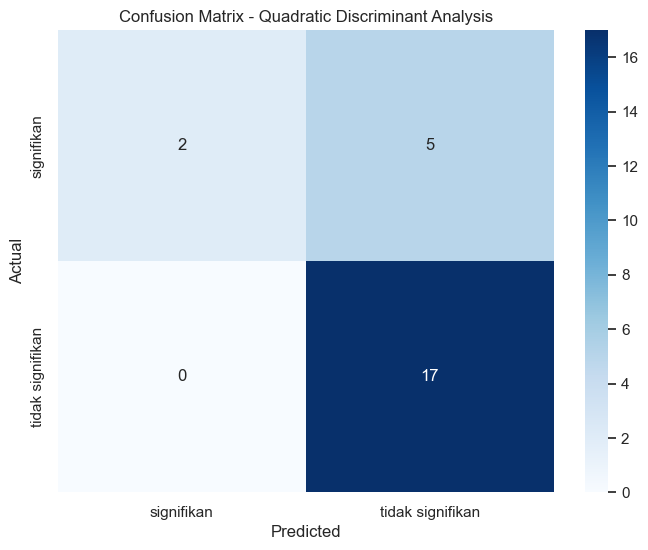

/var/folders/sq/_27zqsss0s304lxljksdbb4r0000gn/T/ipykernel_36040/2495319032.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


Random Forest -  2 Classes:
[[ 3  4]
 [ 2 15]]
Macro AUC : 0.7268907563025211
Macro Specificity : 0.6554621848739496
FPR  : [0.0, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.7142857142857143, 0.7142857142857143, 1.0]
TPR  : [0.0, 0.058823529411764705, 0.11764705882352941, 0.23529411764705882, 0.4117647058823529, 0.4117647058823529, 0.5294117647058824, 0.5294117647058824, 0.6470588235294118, 0.8235294117647058, 0.8823529411764706, 0.8823529411764706, 1.0, 1.0]
TN, FP, FN, TP : [ 3  4  2 15]
                  precision    recall  f1-score   support

      signifikan       0.60      0.43      0.50         7
tidak signifikan       0.79      0.88      0.83        17

        accuracy                           0.75        24
       macro avg       0.69      0.66      0.67        24
    weighted avg       0.73      0.75      0.74        24



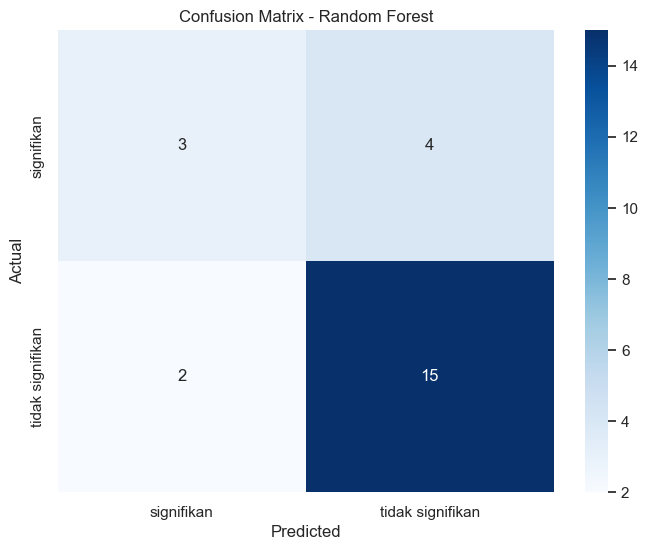

RBF SVM -  2 Classes:
[[ 0  7]
 [ 0 17]]
Macro AUC : 0.7478991596638656
Macro Specificity : 0.5
FPR  : [0.0, 0.0, 0.0, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 1.0]
TPR  : [0.0, 0.058823529411764705, 0.11764705882352941, 0.11764705882352941, 0.35294117647058826, 0.35294117647058826, 0.8235294117647058, 0.8235294117647058, 0.9411764705882353, 0.9411764705882353, 1.0, 1.0]
TN, FP, FN, TP : [ 0  7  0 17]
                  precision    recall  f1-score   support

      signifikan       0.00      0.00      0.00         7
tidak signifikan       0.71      1.00      0.83        17

        accuracy                           0.71        24
       macro avg       0.35      0.50      0.41        24
    weighted avg       0.50      0.71      0.59        24



/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mfarismuzakki/.pyenv/versions/3.10.2/envs/tesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

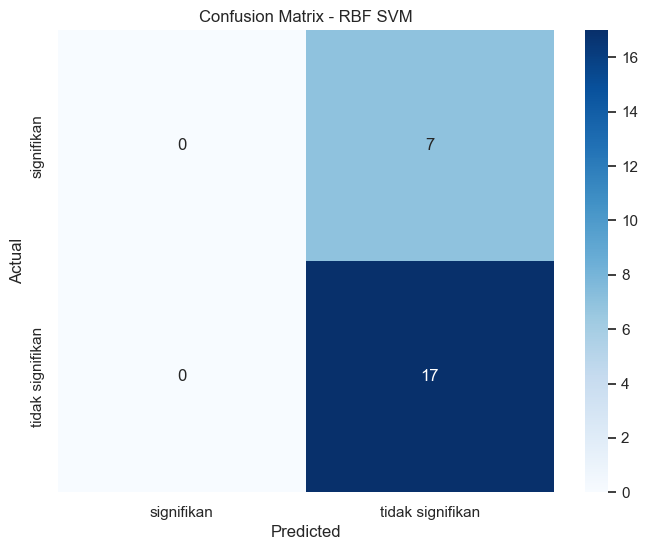

In [13]:
x = pd.concat([x_ct_clinic_lab.iloc[0:33], x_ct_clinic_lab.iloc[57:]])
y = pd.concat([y_2.iloc[0:33], y_2.iloc[57:]])
x_test = x_ct_clinic_lab.iloc[33:57]
y_test = y_2.iloc[33:57]
x_train = x
y_train = y


for name, model in zip(names, classifiers):
    fpr_all = []
    tpr_all = []

    # Train the classifier on the training data
    model.fit(x_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)

    y_test_binarizer = label_binarize(y_test, classes=model.classes_)
    fpr, tpr, _ = roc_curve(y_test_binarizer, y_pred_proba[:, 1])

    fpr_all.append(fpr)
    tpr_all.append(tpr)

    # Calculate metrics for this fold
    class_report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba[:,1], average=None)

    print(f"{name} -  2 Classes:")
    print(confusion_matrix(y_test, y_pred))
    print(f'Macro AUC : {auc}')
    print(f'Macro Specificity : {specificity_score(y_test, y_pred, labels=model.classes_, average="macro")}')
    print(f'FPR  : {fpr_all[0].tolist()}')
    print(f'TPR  : {tpr_all[0].tolist()}')
    print(f'TN, FP, FN, TP : {confusion_matrix(y_test, y_pred).ravel()}')
    print(class_report)

    # Print heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.savefig(f'images/charts/cf_dataval_ct_clin_lab_2_classes_{name.lower().replace(" ", "_")}.png')
    plt.show()